# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

### Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary. 

The goal is to provide recommendations to a used car dealership on what factors influence car prices, helping them understand what consumers value in used cars. This will allow dealers to determine selling prices for their cars that the market will support. As a result of this understanding the key feature (aka. target) of concern for the analysis is price.

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
#from ydata_profiling import ProfileReport
import numpy as np
import sweetviz as sv

from sklearn.feature_selection import SequentialFeatureSelector, SelectFromModel,  RFE
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder, OrdinalEncoder
from sklearn.compose import make_column_transformer, make_column_selector, TransformedTargetRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, StratifiedShuffleSplit, KFold, cross_val_score
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.inspection import permutation_importance
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score
from sklearn import set_config
set_config(display="diagram")

# mute warnings
import warnings
warnings.filterwarnings("ignore")

### Data Understanding
After considering the business understanding, we want to get familiar with our data. Write down some steps that you would take to get to know the dataset and identify any quality issues within. Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

In [2]:
# Load the dataset
df = pd.read_csv("data/vehicles.csv")

In [3]:
# View the dataset
df.head()

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
0,7222695916,prescott,6000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,az
1,7218891961,fayetteville,11900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ar
2,7221797935,florida keys,21000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fl
3,7222270760,worcester / central MA,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ma
4,7210384030,greensboro,4900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nc


In [4]:
# Get dataset information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   region        426880 non-null  object 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  object 
 5   model         421603 non-null  object 
 6   condition     252776 non-null  object 
 7   cylinders     249202 non-null  object 
 8   fuel          423867 non-null  object 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  object 
 11  transmission  424324 non-null  object 
 12  VIN           265838 non-null  object 
 13  drive         296313 non-null  object 
 14  size          120519 non-null  object 
 15  type          334022 non-null  object 
 16  paint_color   296677 non-null  object 
 17  state         426880 non-null  object 
dtypes: f

In [5]:
# Get summary statistics
df.describe(include="all")

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
count,4.268800e+05,426880,4.268800e+05,425675.000000,409234,421603,252776,249202,423867,4.224800e+05,418638,424324,265838,296313,120519,334022,296677,426880
unique,NaN,404,NaN,NaN,42,29649,6,8,5,NaN,6,3,118246,3,4,13,12,51
top,NaN,columbus,NaN,NaN,ford,f-150,good,6 cylinders,gas,NaN,clean,automatic,1FMJU1JT1HEA52352,4wd,full-size,sedan,white,ca
freq,NaN,3608,NaN,NaN,70985,8009,121456,94169,356209,NaN,405117,336524,261,131904,63465,87056,79285,50614
mean,7.311487e+09,NaN,7.519903e+04,2011.235191,NaN,NaN,NaN,NaN,NaN,9.804333e+04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,4.473170e+06,NaN,1.218228e+07,9.452120,NaN,NaN,NaN,NaN,NaN,2.138815e+05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,7.207408e+09,NaN,0.000000e+00,1900.000000,NaN,NaN,NaN,NaN,NaN,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,7.308143e+09,NaN,5.900000e+03,2008.000000,NaN,NaN,NaN,NaN,NaN,3.770400e+04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,7.312621e+09,NaN,1.395000e+04,2013.000000,NaN,NaN,NaN,NaN,NaN,8.554800e+04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,7.315254e+09,NaN,2.648575e+04,2017.000000,NaN,NaN,NaN,NaN,NaN,1.335425e+05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
# Calculate missing values
missing = df.isnull().sum()
missing

id                   0
region               0
price                0
year              1205
manufacturer     17646
model             5277
condition       174104
cylinders       177678
fuel              3013
odometer          4400
title_status      8242
transmission      2556
VIN             161042
drive           130567
size            306361
type             92858
paint_color     130203
state                0
dtype: int64

In [7]:
# Leverage sweetviz and pandas to get an overview of the dataset
# Sweetviz Report
#report = sv.analyze(df)
# save report to file
#report.show_html('SWEETVIZ_Vehicles.html')

# Pandas Profiling Report
#pandas_profiling.ProfileReport(df).to_file("Pandas_Profiling_Report_Vehicles.html")

### Dataset Overview
- Total Rows: 362,867 <br /><br />
- Total Columns: 18 <br /><br />

### Data Types and Features
- Numerical Features: price, year, odometer <br /><br />
    - Note: price is the target value <br /><br />
- Categorical Features: region, manufacturer, model, condition, cylinders, fuel, title_status, transmission, VIN, drive, size, type, paint_color, state <br /><br />
    - Nominal Categorical Features - categories do not have a natural order or ranking: region, manufacturer, model, fuel, title_status, transmission, VIN, drive, type, paint_color, state <br /><br />
    - Ordinal Categorical Features - categories have a natural order or ranking: condition, cylinders, size <br /><br />
- Unique Values in Categorical Features <br /><br />
- Region: 404 unique values <br /><br />
- Manufacturer: 41 unique manufacturers <br /><br />
- Model: 21,555 unique models <br /><br />
- Condition: 6 categories <br /><br />
- Cylinders: 8 categories <br /><br />
- Fuel: 5 types <br /><br />
- Title Status: 6 categories <br /><br />
- Transmission: 3 types <br /><br />
- Drive: 3 types <br /><br />
- Size: 4 categories <br /><br />
- Type: 13 categories <br /><br />
- Paint Color: 12 colors <br /><br />
- State: 51 states (including Washington D.C.)<br /><br />

Feature Statistics
- Price: The average price is approximately &dollar;75199. There's a significant standard deviation, indicating wide price variations. The range is from $0 to over &dollar;3.7 billion, which suggests outliers or data entry errors.<br /><br />
- Year: The cars range from 1900 to 2022, with a median year of 2013. This indicates that most cars are relatively recent.<br /><br />
- Odometer: The average mileage is about 98,043 miles, with values ranging up to 10,000,000 miles, which might be an outlier.<br /><br />
- Condition: Most cars are listed as "good".<br /><br />
- Cylinders: "6 cylinders" is the most common specification.<br /><br />
- Fuel: The majority of cars use gas.<br /><br />
- Transmission: Automatic is the predominant transmission type.<br /><br />
- Drive: "4wd" (four-wheel drive) is common among specified entries.<br /><br />
- Type: Sedans are the most common type of car.<br /><br />
- Paint_color: White is the most frequent color.<br /><br />

### Other Observations
- The dataset is rich in categorical data, which provides a diverse view of the used car market across different regions and specifications. <br /><br />
- The model column has a high number of unique values, indicating a wide variety of car models in the dataset.<br /><br />
- The VIN column also has a high number of unique values, which could be useful for tracking individual cars but may not be as useful for general analysis due to its granularity. <br /><br />

### Data Quality Issues
- Price: Extremely high maximum value likely indicates outliers or errors. <br /><br />
- Odometer: Extremely high maximum value suggests possible outliers.<br /><br />
- Missing Values: Several columns like manufacturer, model, condition, cylinders, fuel, title_status, transmission, VIN, drive, size, type, paint_color have missing values.

### Data Preparation

After our initial exploration and fine tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`. 

In [8]:
# Display dataframe shape
print(df.shape)

# Remove non-impactful or overly granular features i.e., id, VIN, model (21,555 unique values and somewhat correlated with manufacturer), and region (404 unique values and somewhat correlated with state)  
df = df.drop(['id', 'VIN', 'model', 'region'], axis=1)

# Remove rows with missing values
df = df.dropna()

# Remove unrealistic values for price, odometer determined by visual inspection
df = df[(df['price'] <= 600000) & (df['price'] >= 100) & (df['odometer'] <= 500000)]

# Display dataframe shape
print(df.shape)

(426880, 18)
(75486, 14)


#### Handling Outliers
Quartiles and DBSCAN can be used to handle outliers. In the case of this dataset we'll use DBSCAN to identify outliers as it is robust enough to handle different distributions.

### Pre-Outlier Handling: Statistics and visualizations

In [9]:
print(df.shape)
df.describe()

(75486, 14)


,price,year,odometer
count,75486.000000,75486.000000,75486.000000
mean,13900.829094,2008.100085,118148.042577
std,12479.336951,10.266475,61912.590293
min,100.000000,1900.000000,0.000000
25%,5500.000000,2005.000000,75000.000000
50%,9900.000000,2010.000000,115541.000000
75%,18000.000000,2014.000000,156808.250000
max,195000.000000,2022.000000,500000.000000


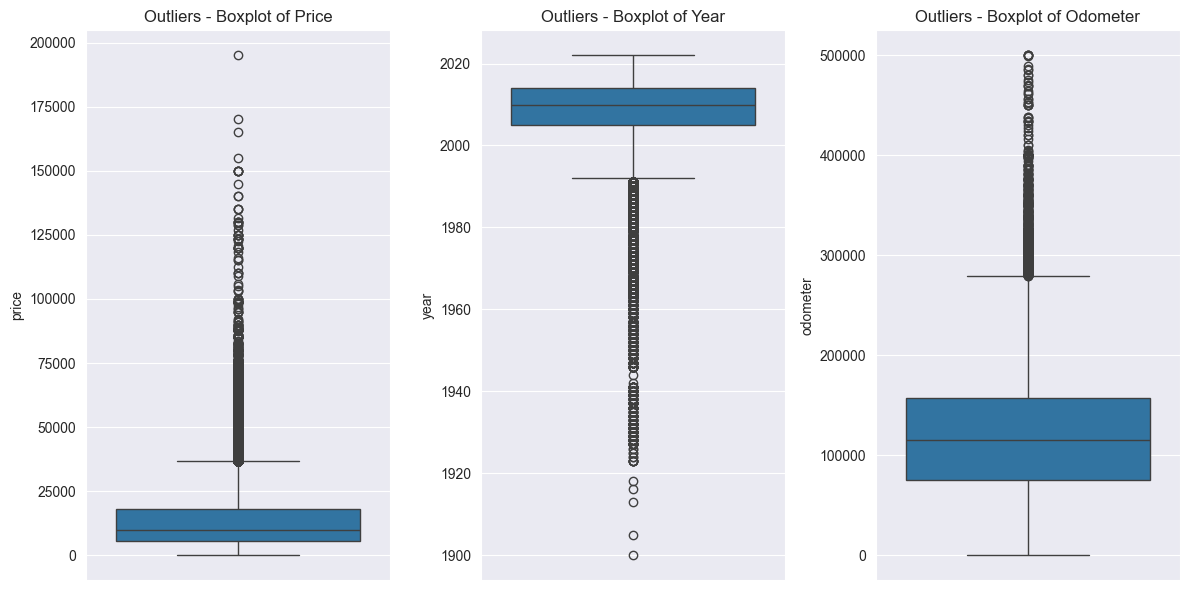

In [10]:
# Plotting boxplots for price, year, and odometer
df_outliers= df[['price', 'year', 'odometer']].dropna()

plt.figure(figsize=(12, 6), facecolor='white')
plt.subplot(1, 3, 1)
sns.boxplot(y=df_outliers['price'])
plt.title('Outliers - Boxplot of Price')

plt.subplot(1, 3, 2)
sns.boxplot(y=df_outliers['year'])
plt.title('Outliers - Boxplot of Year')

plt.subplot(1, 3, 3)
sns.boxplot(y=df_outliers['odometer'])
plt.title('Outliers - Boxplot of Odometer')

plt.tight_layout()
plt.show()

In [11]:

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN


# Handle outliers in price, odometer, and year using DBSCAN
outlier_features = ['price', 'odometer', 'year']

# Function to identify outliers using DBSCAN Clustering
def dbscan_outliers(df, feature, eps, min_samples):
    X = df[[feature]]
    # Standardize the data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    # DBSCAN Clustering 
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    # Fit the model
    dbscan.fit(X_scaled)
    labels = dbscan.labels_
    # Remove outliers
    no_outliers = labels != -1
    return no_outliers

# Loop through features and process outliers
for feature in outlier_features:
    outliers_mask = dbscan_outliers(df, feature, eps=0.2, min_samples=5)
    df_prepped = df[outliers_mask]

### Post-Outlier Handling: Statistics and Visualizations

In [12]:
print(df_prepped.shape)
df_prepped.describe()

(75481, 14)


,price,year,odometer
count,75481.000000,75481.000000,75481.000000
mean,13899.693234,2008.106557,118151.984234
std,12476.695503,10.235822,61909.761922
min,100.000000,1923.000000,0.000000
25%,5500.000000,2005.000000,75000.000000
50%,9900.000000,2010.000000,115549.000000
75%,18000.000000,2014.000000,156811.000000
max,195000.000000,2022.000000,500000.000000


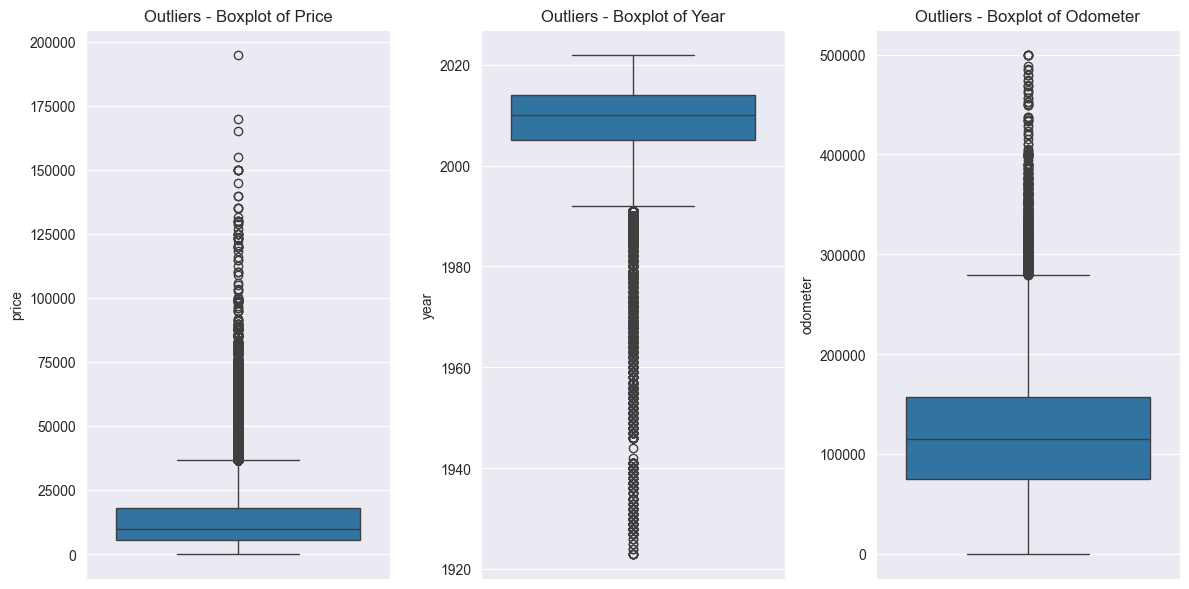

In [13]:
# Plotting boxplots for price, year, and odometer
df_outliers = df_prepped[['price', 'year', 'odometer']].dropna()

plt.figure(figsize=(12, 6), facecolor='white')
plt.subplot(1, 3, 1)
sns.boxplot(y=df_outliers['price'])
plt.title('Outliers - Boxplot of Price')

plt.subplot(1, 3, 2)
sns.boxplot(y=df_outliers['year'])
plt.title('Outliers - Boxplot of Year')

plt.subplot(1, 3, 3)
sns.boxplot(y=df_outliers['odometer'])
plt.title('Outliers - Boxplot of Odometer')

plt.tight_layout()
plt.show()

### Visualizations of Features (independent variables) against Price (target/dependent variable)

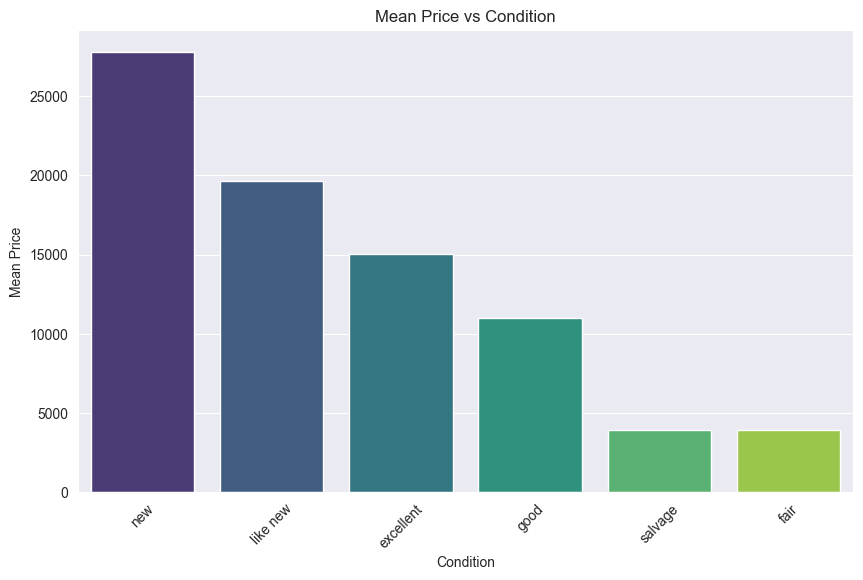

In [14]:
# Grouping by 'condition' and calculating the mean price
price_condition = df_prepped.groupby('condition')['price'].mean().reset_index()

# Sorting the DataFrame by mean price in descending order
price_condition_sorted = price_condition.sort_values(by='price', ascending=False)

# Plotting the mean price vs condition
plt.figure(figsize=(10, 6), facecolor='white')
sns.barplot(x ='condition', y='price', data=price_condition_sorted, palette='viridis', legend=False)
plt.title('Mean Price vs Condition')
plt.xlabel('Condition')
plt.ylabel('Mean Price')
plt.xticks(rotation=45)
plt.show()

Observation: There is a direct correlation between condition and mean price with 'new' commanding the highest mean price, and 'fair' the lowest.

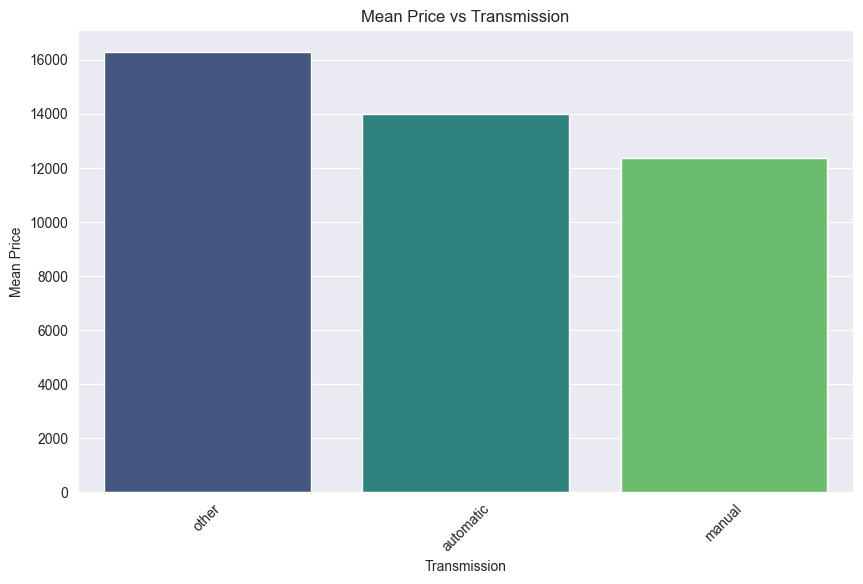

In [15]:
# Grouping by 'transmission' and calculating the mean price
price_transmission = df_prepped.groupby('transmission')['price'].mean().reset_index()

# Sorting the DataFrame by mean price in descending order
price_transmission_sorted = price_transmission.sort_values(by='price', ascending=False)

# Plotting the mean price vs transmission
plt.figure(figsize=(10, 6), facecolor='white')
sns.barplot(x ='transmission', y='price', data=price_transmission_sorted, palette='viridis')
plt.title('Mean Price vs Transmission')
plt.xlabel('Transmission')
plt.ylabel('Mean Price')
plt.xticks(rotation=45)
plt.show()

Observation: Other transmission commands the highest mean price. This may relate to some luxury/exotic cars having specialized transmission options. 

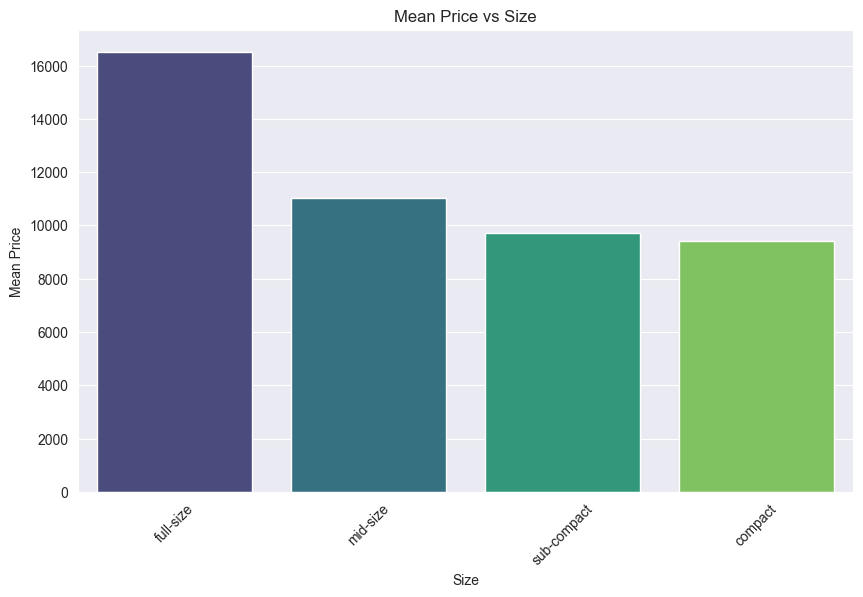

In [16]:
# Grouping by 'size' and calculating the mean price
price_size = df_prepped.groupby('size')['price'].mean().reset_index()

# Sorting the DataFrame by mean price in descending order
price_size_sorted = price_size.sort_values(by='price', ascending=False)

# Plotting the mean price vs size
plt.figure(figsize=(10, 6), facecolor='white')
sns.barplot(x ='size', y='price', data=price_size_sorted, palette='viridis')
plt.title('Mean Price vs Size')
plt.xlabel('Size')
plt.ylabel('Mean Price')
plt.xticks(rotation=45)
plt.show()

Observation: There is a direct correlation between size and price with full-size commanding the highest mean price. Interestingly, sub-compacts appear to command a higher mean price than compacts which command the lowest mean price. 

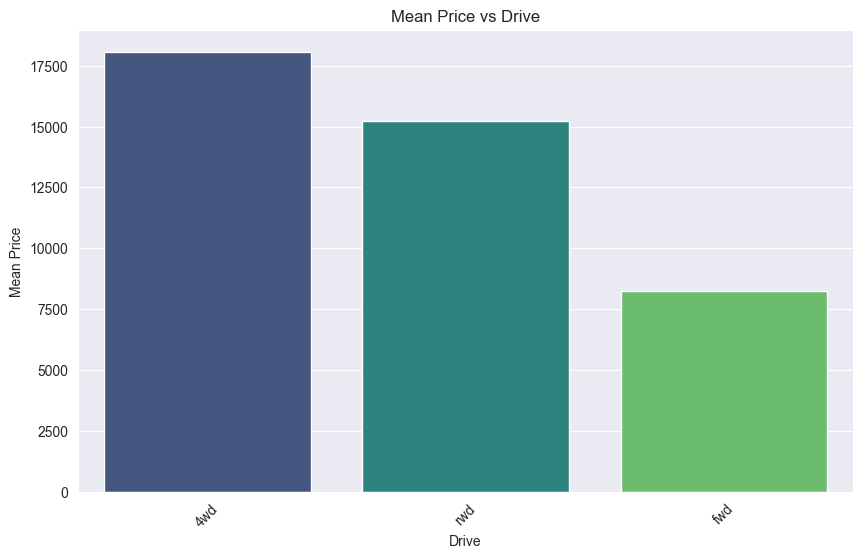

In [17]:
# Grouping by 'drive' and calculating the mean price
price_drive = df_prepped.groupby('drive')['price'].mean().reset_index()

# Sorting the DataFrame by mean price in descending order
price_drive_sorted = price_drive.sort_values(by='price', ascending=False)

# Plotting the mean price vs drive
plt.figure(figsize=(10, 6), facecolor='white')
sns.barplot(x ='drive', y='price', data=price_drive_sorted, palette='viridis')
plt.title('Mean Price vs Drive')
plt.xlabel('Drive')
plt.ylabel('Mean Price')
plt.xticks(rotation=45)
plt.show()

Observation: 4-wheel drive commands the highest mean price. Front-wheel drive commands the lowest mean price.

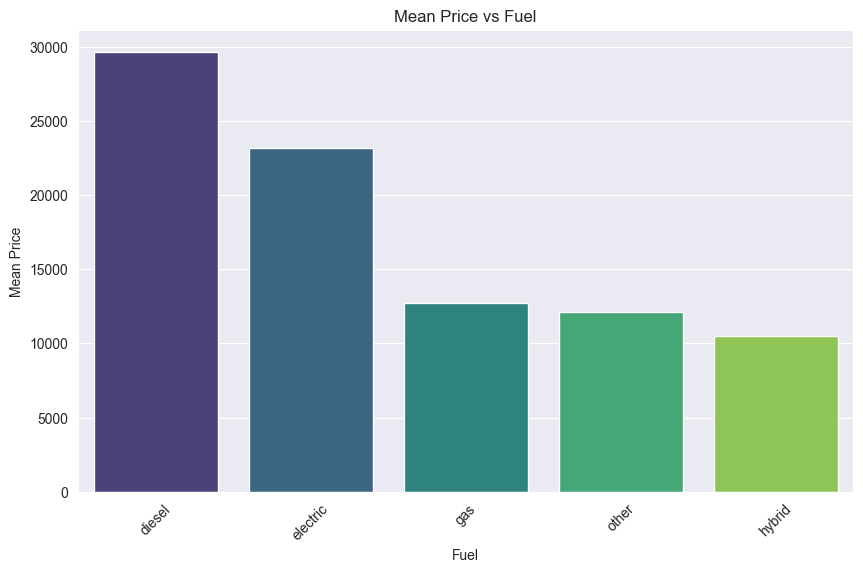

In [18]:
# Grouping by 'fuel' and calculating the mean price
price_fuel = df_prepped.groupby('fuel')['price'].mean().reset_index()

# Sorting the DataFrame by mean price in descending order
price_fuel_sorted = price_fuel.sort_values(by='price', ascending=False)

# Plotting the mean price vs fuel
plt.figure(figsize=(10, 6), facecolor='white')
sns.barplot(x ='fuel', y='price', data=price_fuel_sorted, palette='viridis')
plt.title('Mean Price vs Fuel')
plt.xlabel('Fuel')
plt.ylabel('Mean Price')
plt.xticks(rotation=45)
plt.show()

Observation: Diesel commands the highest mean price. Hybrid commands the lowest mean price.

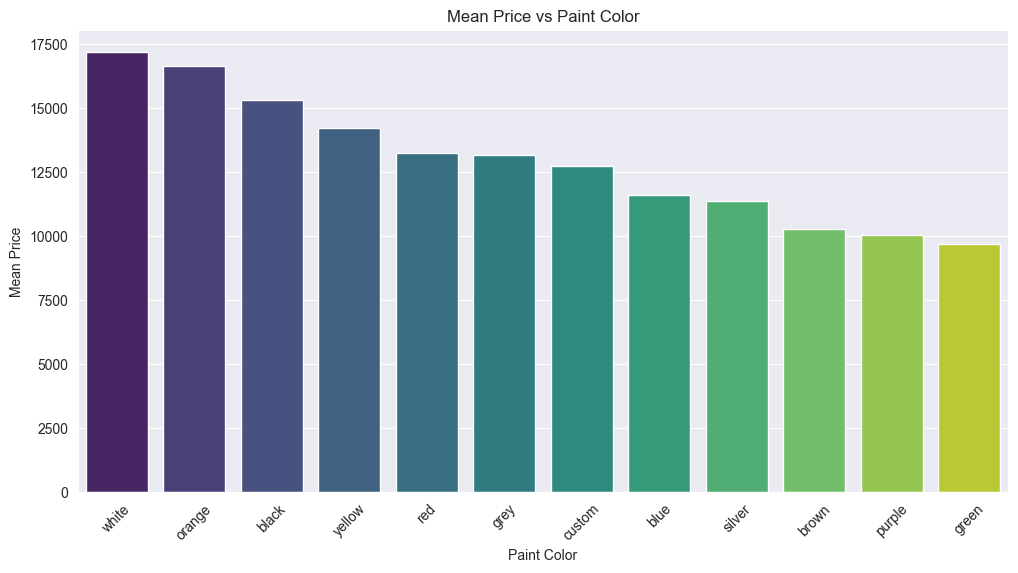

In [19]:
# Grouping by 'paint_color' and calculating the mean price
price_paint_color = df_prepped.groupby('paint_color')['price'].mean().reset_index()

# Sorting the DataFrame by mean price in descending order
price_paint_color_sorted = price_paint_color.sort_values(by='price', ascending=False)

# Plotting the mean price vs paint color
plt.figure(figsize=(12, 6), facecolor='white')
sns.barplot(x ='paint_color', y='price', data=price_paint_color_sorted, palette='viridis')
plt.title('Mean Price vs Paint Color')
plt.xlabel('Paint Color')
plt.ylabel('Mean Price')
plt.xticks(rotation=45)
plt.show()

Observation: White commands the highest mean price, followed by orange (strangely enough - again may be due to the presence of exotic cars in the dataset), and black. Green commands the lowest mean price.

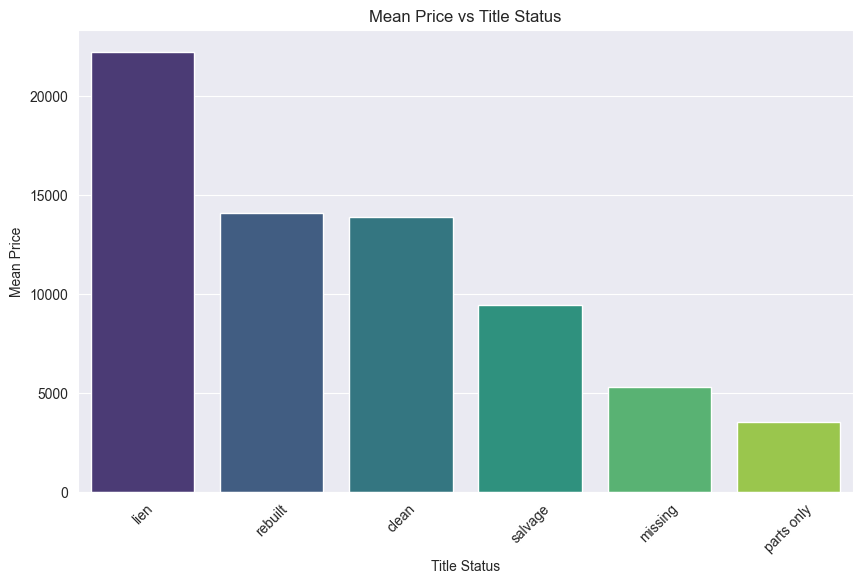

In [20]:
# Grouping by 'title_status' and calculating the mean price
price_title_status = df_prepped.groupby('title_status')['price'].mean().reset_index()

# Sorting the DataFrame by mean price in descending order
price_title_status_sorted = price_title_status.sort_values(by='price', ascending=False)

# Plotting the mean price vs title status
plt.figure(figsize=(10, 6), facecolor='white')
sns.barplot(x ='title_status', y='price', data=price_title_status_sorted, palette='viridis')
plt.title('Mean Price vs Title Status')
plt.xlabel('Title Status')
plt.ylabel('Mean Price')
plt.xticks(rotation=45)
plt.show()

Obervation: Vehicles with lien titles command the highest mean price, and vehicles with parts-only titles command the lowest mean price. This makes sense as a  parts-only title basically means the vehicle is junk.

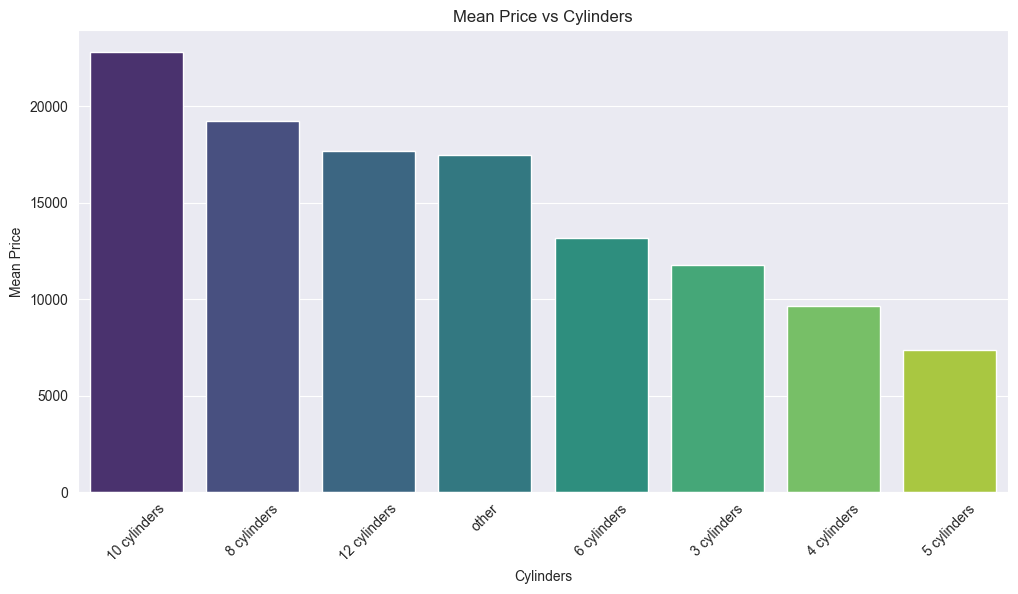

In [21]:
# Grouping by 'cylinders' and calculating the mean price
price_cylinders = df_prepped.groupby('cylinders')['price'].mean().reset_index()

# Sorting the DataFrame by mean price in descending order
price_cylinders_sorted = price_cylinders.sort_values(by='price', ascending=False)

# Plotting the mean price vs cylinders
plt.figure(figsize=(12, 6), facecolor='white')
sns.barplot(x ='cylinders', y='price', data=price_cylinders_sorted, palette='viridis')
plt.title('Mean Price vs Cylinders')
plt.xlabel('Cylinders')
plt.ylabel('Mean Price')
plt.xticks(rotation=45)
plt.show()

Observation: 10 cylinders commands the highest mean price, and 5 cylinders commands the lowest mean price.

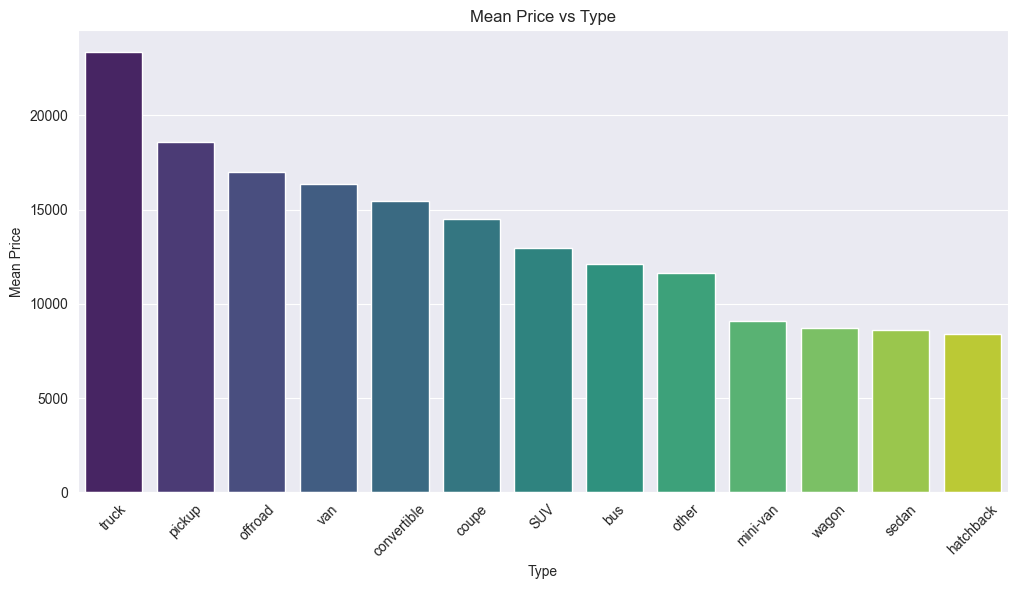

In [22]:
# Grouping by 'type' and calculating the mean price
price_type = df_prepped.groupby('type')['price'].mean().reset_index()

# Sorting the DataFrame by mean price in descending order
price_type_sorted = price_type.sort_values(by='price', ascending=False)

# Plotting the mean price vs type
plt.figure(figsize=(12, 6), facecolor='white')
sns.barplot(x ='type', y='price', data=price_type_sorted, palette='viridis')
plt.title('Mean Price vs Type')
plt.xlabel('Type')
plt.ylabel('Mean Price')
plt.xticks(rotation=45)
plt.show()

Observation: Trucks command the highest mean price, and hatchbacks command the lowest mean price.

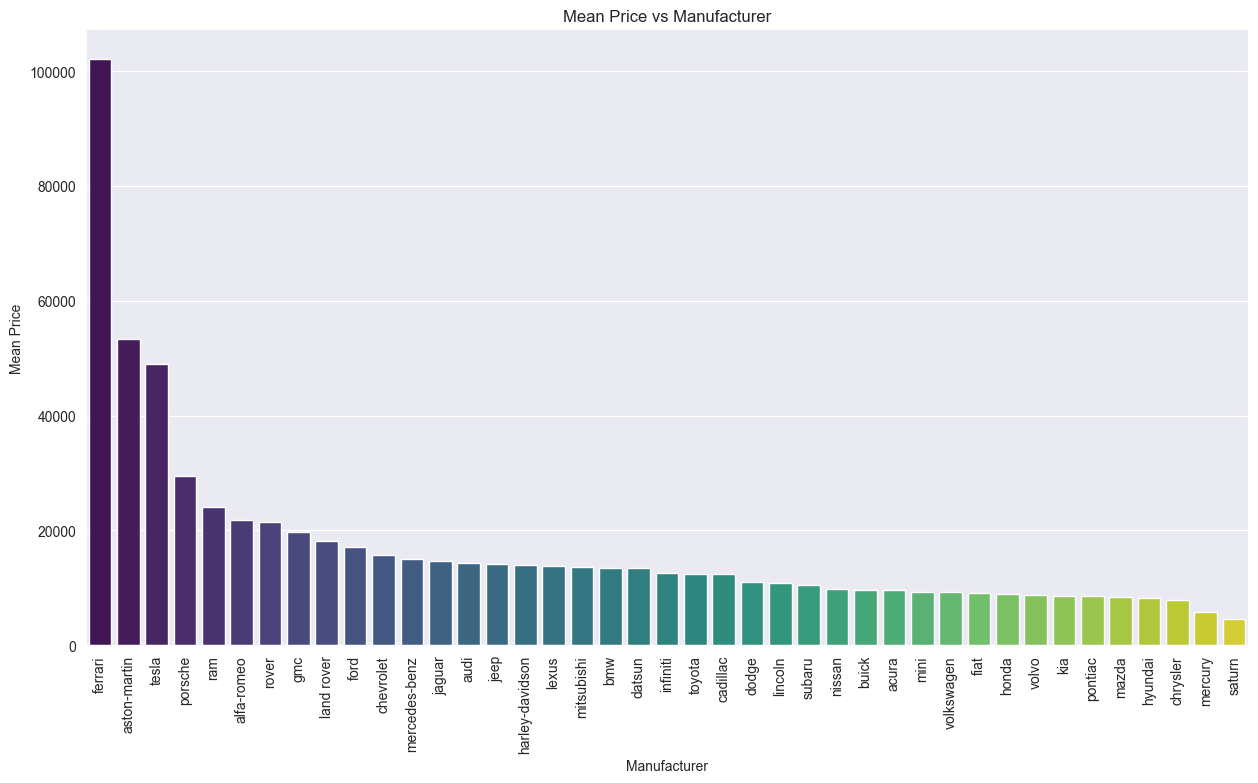

In [23]:
# Grouping by 'manufacturer' and calculating the mean price
price_manufacturer = df_prepped.groupby('manufacturer')['price'].mean().reset_index()

# Sorting the DataFrame by mean price in descending order
price_manufacturer_sorted = price_manufacturer.sort_values(by='price', ascending=False)

# Plotting the mean price vs manufacturer
plt.figure(figsize=(15, 8), facecolor='white')
sns.barplot(x ='manufacturer', y='price', data=price_manufacturer_sorted, palette='viridis')
plt.title('Mean Price vs Manufacturer')
plt.xlabel('Manufacturer')
plt.ylabel('Mean Price')
plt.xticks(rotation=90)
plt.show()

Observation: Luxury brands such as Ferrari, Aston Martin, and Tesla command the highest mean price, and Saturn commands the lowest mean price.

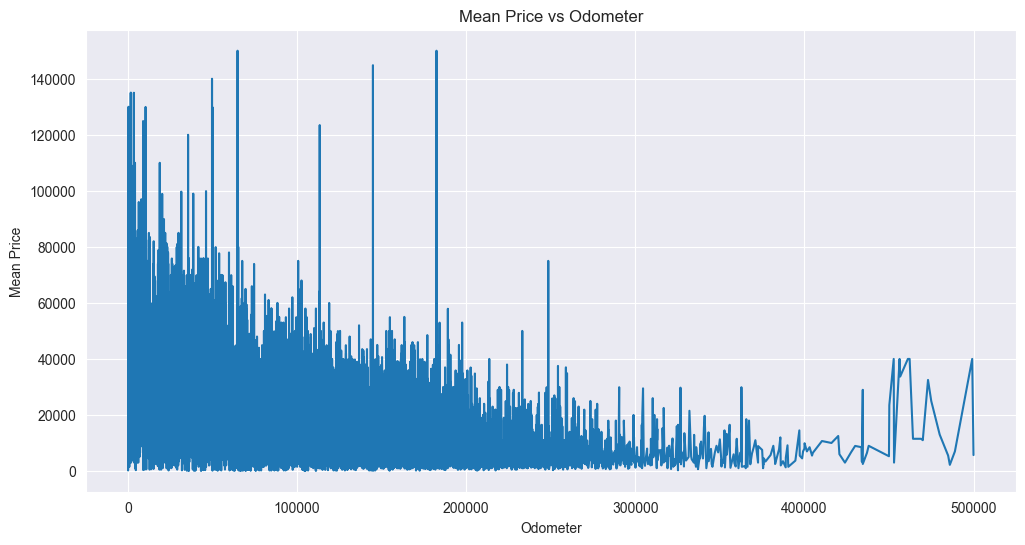

In [24]:
# Grouping by 'odometer' and calculating the mean price
price_odometer = df_prepped.groupby('odometer')['price'].mean().reset_index()

# Plotting the mean price vs odometer
plt.figure(figsize=(12, 6), facecolor='white')
sns.lineplot(x='odometer', y='price', data=price_odometer, palette='viridis')
plt.title('Mean Price vs Odometer')
plt.xlabel('Odometer')
plt.ylabel('Mean Price')
plt.show()

Observation: The mean price tends to decrease with increasing odometer. 

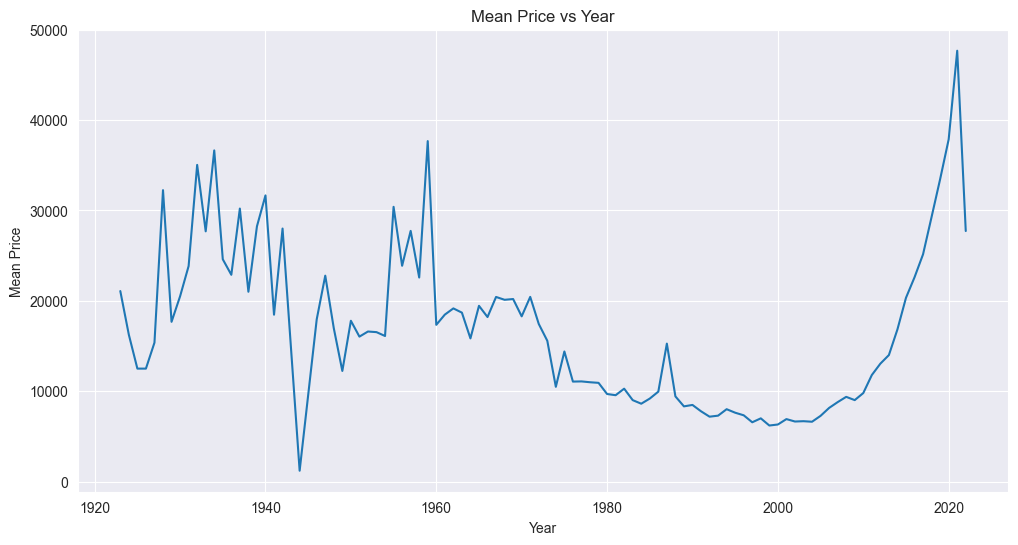

In [25]:
# Grouping by 'year' and calculating the mean price
price_year = df_prepped.groupby('year')['price'].mean().reset_index()

# Plotting the mean price vs year
plt.figure(figsize=(12, 6), facecolor='white')
sns.lineplot(x='year', y='price', data=price_year, palette='viridis')
plt.title('Mean Price vs Year')
plt.xlabel('Year')
plt.ylabel('Mean Price')
plt.show()

Observation: For vehicles made in the last 20 years or so the mean price tends to increase with increasing year. There are interesting spikes for vehicles in the early 1900s and those made in the 1950s and 1960s. This is possibly due to these being collectible vehicles.

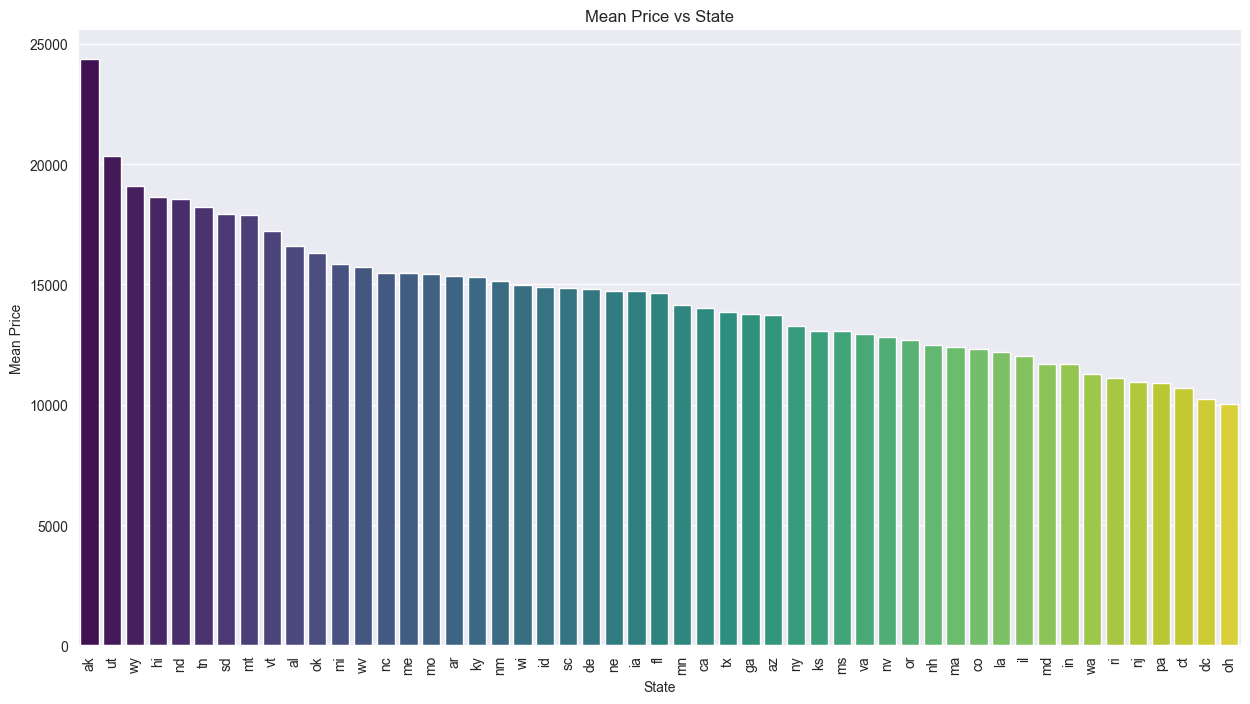

In [26]:
# Grouping by 'state' and calculating the mean price
price_state = df_prepped.groupby('state')['price'].mean().reset_index()

# Sorting the DataFrame by mean price in descending order
price_state_sorted = price_state.sort_values(by='price', ascending=False)

# Plotting the mean price vs state
plt.figure(figsize=(15, 8), facecolor='white')
sns.barplot(x='state', y='price', data=price_state_sorted, palette='viridis')
plt.title('Mean Price vs State')
plt.xlabel('State')
plt.ylabel('Mean Price')
plt.xticks(rotation=90)
plt.show()

Observation: Vehicles in Alaska command the highest mean price and those in Ohio command the lowest mean price.

### Feature Engineering

Nominal Categorical Features - categories do not have a natural order or ranking: 
- manufacturer
- fuel
- title_status
- transmission
- drive
- type
- paint_color
- state

Ordinal Categorical Features - categories have a natural order or ranking: 
- condition
- cylinders
- size

In [27]:
# Identifying nominal and ordinal categorical features
nominal_features = ['manufacturer', 'fuel', 'title_status', 'transmission', 'drive', 'type', 'paint_color', 'state']
ordinal_features = ['condition', 'cylinders', 'size']

# Converting nominal features using one-hot encoding
#df = pd.get_dummies(df, columns=nominal_features, drop_first=True)
df_prepped = pd.get_dummies(df_prepped, columns=nominal_features, drop_first=True)

# Mapping ordinal features to integer values
ordinal_mappings = {
    'condition': {'new': 5, 'like new': 4, 'excellent': 3, 'good': 2, 'fair': 1, 'salvage': 0},
    'cylinders': {'12 cylinders': 12, '10 cylinders': 10, '8 cylinders': 8, '6 cylinders': 6, '5 cylinders': 5, '4 cylinders': 4, '3 cylinders': 3, 'other': 2},
    'size': {'full-size': 3, 'mid-size': 2, 'compact': 1, 'sub-compact': 0}
}

for feature, mapping in ordinal_mappings.items():
    df_prepped[feature] = df_prepped[feature].map(mapping)

# Displaying the head of the updated dataframe
df_prepped.head()

,price,year,condition,cylinders,odometer,size,manufacturer_alfa-romeo,manufacturer_aston-martin,manufacturer_audi,manufacturer_bmw,...,state_sd,state_tn,state_tx,state_ut,state_va,state_vt,state_wa,state_wi,state_wv,state_wy
31,15000,2013.0,3,6,128000.0,3,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
55,19900,2004.0,2,8,88000.0,3,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
59,14000,2012.0,3,6,95000.0,3,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
65,22500,2001.0,2,8,144700.0,3,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
73,15000,2017.0,3,8,90000.0,2,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [28]:
df_prepped.dtypes

price          int64
year         float64
condition      int64
cylinders      int64
odometer     float64
              ...   
state_vt        bool
state_wa        bool
state_wi        bool
state_wv        bool
state_wy        bool
Length: 132, dtype: object

In [29]:
# Update data types
# Year should be an integer
df_prepped['year'] = df_prepped['year'].astype(int)
# Cylinders should be an integer
df_prepped['cylinders'] = df_prepped['cylinders'].astype(int)
# Odometer should be an integer
df_prepped['odometer'] = df_prepped['odometer'].astype(int)

In [30]:
df_prepped.dtypes

price        int64
year         int64
condition    int64
cylinders    int64
odometer     int64
             ...  
state_vt      bool
state_wa      bool
state_wi      bool
state_wv      bool
state_wy      bool
Length: 132, dtype: object

In [31]:
df_prepped['price'].describe()

count     75481.000000
mean      13899.693234
std       12476.695503
min         100.000000
25%        5500.000000
50%        9900.000000
75%       18000.000000
max      195000.000000
Name: price, dtype: float64

In [32]:
df_prepped['odometer'].describe()

count     75481.000000
mean     118151.984234
std       61909.761922
min           0.000000
25%       75000.000000
50%      115549.000000
75%      156811.000000
max      500000.000000
Name: odometer, dtype: float64

#### Most of the features are binary valued, so it was decided to scale the values of the non-binary features "price", "odometer", "year" to reduce imbalance

In [33]:
df_prepped['price'] = df_prepped['price'].div(10000)
df_prepped['odometer'] = df_prepped['odometer'].div(100000)
df_prepped['year'] = df_prepped['year'].div(1000)

### Feature Selection

In [34]:
### Spit dataset into independent and dependent variables
X = df_prepped.drop('price', axis=1)
y = df_prepped['price']

# Save y dataset
y.to_csv('y.csv', index=False)

X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 75481 entries, 31 to 426833
Columns: 131 entries, year to state_wy
dtypes: bool(126), float64(2), int64(3)
memory usage: 12.5 MB


### Identify the most impactful features using permutation importance

In [35]:
# Split dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create pipeline to perform feature selection
model = Pipeline([('scale', StandardScaler()), ('linear', LinearRegression())])
model.fit(X_train, y_train)

Pipeline(steps=[('scale', StandardScaler()), ('linear', LinearRegression())])

In [36]:
r = permutation_importance(model,X_test, y_test,n_repeats=30,random_state=42)
perm=pd.DataFrame({"Column":X.columns, "Importance":r.importances_mean}).sort_values(by = "Importance", ascending = False)

In [37]:
len(perm.query('Importance<0'))

4

In [38]:
len(perm.query('Importance>0'))

127

In [39]:
perm.query('Importance>0.000').head(20)

,Column,Importance
3,odometer,0.380404
46,fuel_gas,0.139624
0,year,0.084516
2,cylinders,0.062941
56,drive_fwd,0.060260
67,type_truck,0.038632
1,condition,0.026129
115,state_oh,0.023898
114,state_ny,0.023602
47,fuel_hybrid,0.021791


In [40]:
neg_imp_features = perm.query('Importance<=0')['Column'].unique()
print('Negative importance features: ',neg_imp_features, sep='\n')

pos_imp_features = perm.query('Importance>0')['Column'].unique()
print('Positive importance features: ',pos_imp_features, sep='\n')

Negative importance features: 
['paint_color_purple' 'type_wagon' 'manufacturer_gmc' 'manufacturer_rover']
Positive importance features: 
['odometer' 'fuel_gas' 'year' 'cylinders' 'drive_fwd' 'type_truck'
 'condition' 'state_oh' 'state_ny' 'fuel_hybrid' 'state_pa' 'state_fl'
 'manufacturer_ferrari' 'drive_rwd' 'state_ca' 'state_nj' 'state_tx'
 'type_coupe' 'state_wi' 'state_ma' 'state_va' 'manufacturer_nissan'
 'state_il' 'type_pickup' 'state_ia' 'manufacturer_ford'
 'manufacturer_tesla' 'state_co' 'state_in' 'state_ct' 'state_or'
 'state_nc' 'manufacturer_porsche' 'state_az' 'state_mn'
 'type_convertible' 'state_mi' 'state_ks' 'manufacturer_dodge'
 'manufacturer_chrysler' 'state_id' 'state_dc' 'state_ri' 'state_vt'
 'state_wa' 'size' 'type_van' 'manufacturer_chevrolet'
 'title_status_rebuilt' 'state_md' 'paint_color_silver' 'state_ky'
 'state_nh' 'transmission_manual' 'state_nm' 'manufacturer_bmw'
 'manufacturer_hyundai' 'state_sc' 'manufacturer_kia'
 'manufacturer_volkswagen' 'state_

Positive permutation importance values identify features that are crucial for the model's predictive accuracy, while negative permutation importance values highlight features whose original order might not have been beneficial, potentially indicating areas for further investigation or feature engineering. Both types of values offer valuable insights into the behavior of the model and the importance of individual features. Will we remove negative importance features from the dataset leaving 127 features to be used for modeling. 

127 features is a large number of dimensions and I suspect it caused a failure of K-Fold cross-validation for the Linear Regression model in the first iteration of this analysis. We will apply primary component analysis (PCA) to reduce the dimensionality.

### Apply PCA to reduce the dimensionality of the dataset

Number of components to capture 80% variance: 20
Cumulative Variance explained by these components: 0.8019850326549288


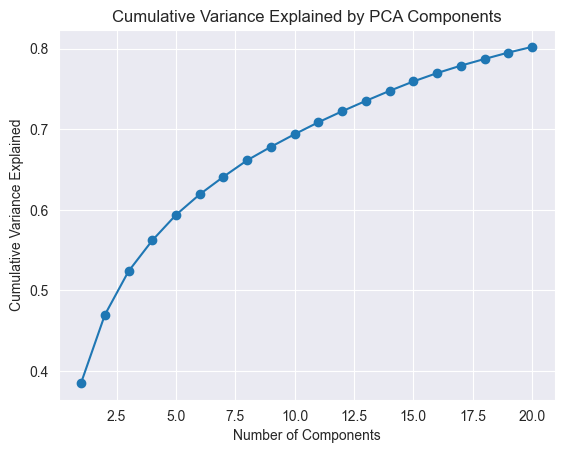

In [41]:
# Apply PCA with a number of components that captures around 80% of the variance
pca_80 = PCA(n_components=0.8)

# Final dataset
X_final = pd.DataFrame(pca_80.fit_transform(df_prepped[pos_imp_features]))

# Display the number of components and the explained variance
n_components_80 = pca_80.n_components_
explained_variance_80 = pca_80.explained_variance_ratio_
cumulative_variance_80 = np.cumsum(explained_variance_80)

# Print the number of components and the cumulative variance
print('Number of components to capture 80% variance:', n_components_80)
print('Cumulative Variance explained by these components:', cumulative_variance_80[-1])

# Plot the cumulative variance
plt.figure(facecolor='white')
plt.plot(range(1, n_components_80 + 1), cumulative_variance_80, marker='o')
plt.title('Cumulative Variance Explained by PCA Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Variance Explained')
plt.grid(True)
plt.show()

Loadings:
[[ 4.12511811e-02  4.56903235e-01 -1.64095494e-01 ...  5.55836566e-03
   7.67855183e-03 -3.38004150e-02]
 [-2.18139762e-02 -2.92515324e-03  4.82678356e-02 ... -4.86536738e-02
   2.44862187e-01  1.01847766e-01]
 [-1.20767498e-03 -3.04078715e-03 -2.60710761e-03 ... -6.91613702e-03
  -3.56843668e-03 -1.52730139e-03]
 ...
 [-1.75852815e-05  1.08583404e-03  9.64221805e-05 ... -3.47681949e-04
   2.87170868e-04  7.78080366e-04]
 [ 3.32994816e-05  5.10158956e-06  9.89566196e-05 ...  7.32165592e-05
   8.75201486e-05 -2.42410618e-05]
 [-4.80154090e-04  2.82804621e-03  8.95842544e-03 ...  4.66626043e-03
  -8.30196558e-03 -1.08652651e-02]]
(127, 20)


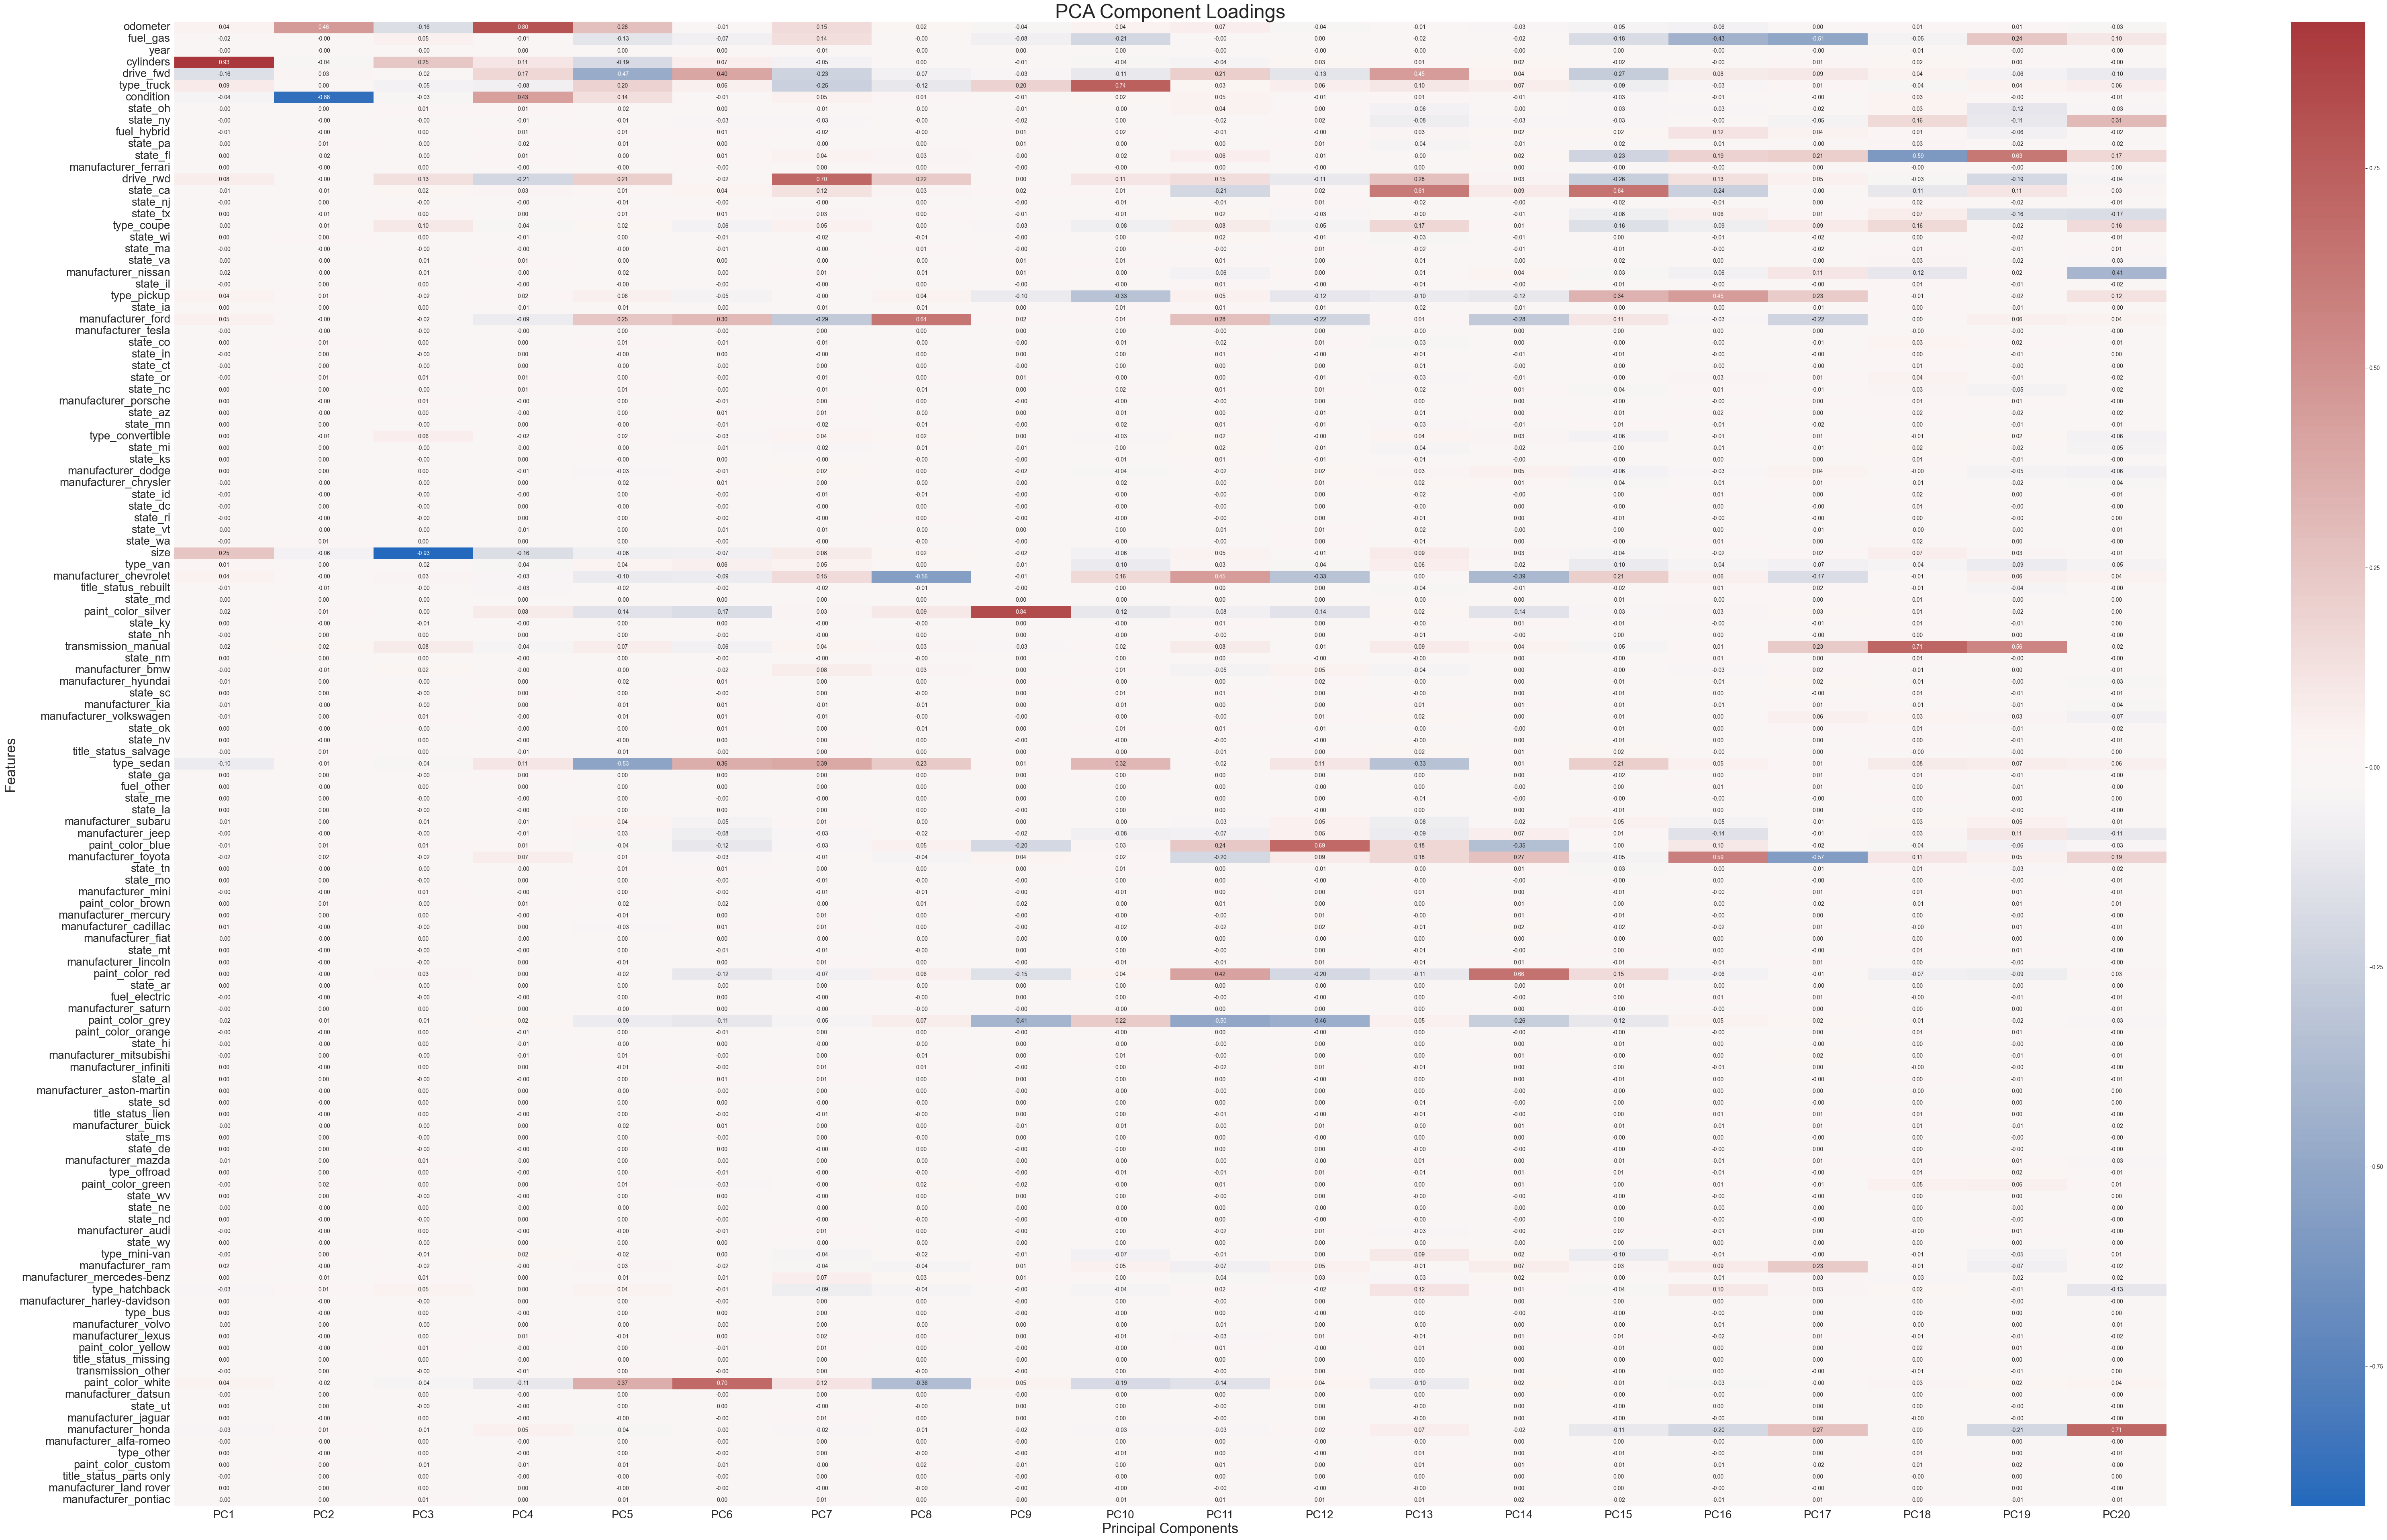

In [42]:
# Assuming 'pca' is your PCA object and 'X' is your original data
loadings = pca_80.components_.T  # Transpose to align with original features

print('Loadings:')
print(loadings)
print(loadings.shape)

# Create a DataFrame of loadings with feature names
features = df_prepped[pos_imp_features].columns
loadings_df = pd.DataFrame(loadings, columns=[f'PC{i+1}' for i in range(loadings.shape[1])], index=features)

# Plotting a heatmap of loadings
plt.figure(figsize=(80, 48))
heatmap =sns.heatmap(loadings_df, cmap='vlag', annot=True, fmt=".2f")

# Increase font size of x and y tick labels
heatmap.tick_params(axis='x', labelsize=20)
heatmap.tick_params(axis='y', labelsize=20)

plt.title('PCA Component Loadings', fontsize=35)  # Increase title font size
plt.xlabel('Principal Components', fontsize=25)  # Increase x-axis label font size
plt.ylabel('Features', fontsize=25)  # Increase y-axis label font size
plt.show()

In [43]:
# Top Features per Component
top_features_per_component = {}
n_top_features = 3  # Number of top features to list for each component

for column in loadings_df.columns:
    # Sort the features based on the absolute loadings values in descending order
    sorted_features = loadings_df[column].abs().sort_values(ascending=False)
    # Select the top n features
    top_features = sorted_features.head(n_top_features).index.tolist()
    top_features_per_component[column] = top_features

# Display the top features for each principal component
top_component_features_df = pd.DataFrame(top_features_per_component)

# Write to csv
top_component_features_df.to_csv('top_component_features.csv', index=False)
top_component_features_df

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20
0,cylinders,condition,size,odometer,type_sedan,paint_color_white,drive_rwd,manufacturer_ford,paint_color_silver,type_truck,paint_color_grey,paint_color_blue,state_ca,paint_color_red,state_ca,manufacturer_toyota,manufacturer_toyota,transmission_manual,state_fl,manufacturer_honda
1,size,odometer,cylinders,condition,drive_fwd,drive_fwd,type_sedan,manufacturer_chevrolet,paint_color_grey,type_pickup,manufacturer_chevrolet,paint_color_grey,drive_fwd,manufacturer_chevrolet,type_pickup,type_pickup,fuel_gas,state_fl,transmission_manual,manufacturer_nissan
2,drive_fwd,size,odometer,drive_rwd,paint_color_white,type_sedan,manufacturer_ford,paint_color_white,paint_color_blue,type_sedan,paint_color_red,manufacturer_chevrolet,type_sedan,paint_color_blue,drive_fwd,fuel_gas,manufacturer_honda,state_ny,fuel_gas,state_ny


### Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

In [44]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.2, random_state=42)

In [45]:
print(X_train.shape)
print(X_train.head())

(60384, 20)
             0         1         2         3         4         5         6   \
18273  2.129072 -0.694469  0.086133 -0.321462 -0.558107 -0.545504 -0.120850   
40851  1.780584 -1.374631 -0.077349  0.703698 -1.241060  0.425240  0.046389   
70810 -0.139529  1.070917  0.259237  0.669027 -0.201431 -0.099054 -0.394765   
35360  2.233809  0.911008 -0.133428  0.463227 -0.268095 -0.564249 -0.007836   
52851 -2.229904 -0.961347 -0.226117  0.802543 -0.314436  0.261717  0.155714   

             7         8         9         10        11        12        13  \
18273 -0.483470 -0.382881 -0.470926  0.539592  0.434244 -0.067528 -0.693593   
40851  0.154704 -0.122258 -0.048251 -0.021104  0.199284 -0.054468  0.208265   
70810 -0.110985 -0.215686 -0.178407  0.269161 -0.135457  0.232465  0.998547   
35360 -0.507426 -0.434500 -0.405621  0.551356  0.391061 -0.131113 -0.760787   
52851  0.096272 -0.109663  0.147268  0.166368  0.070635 -0.144708  0.010233   

             14        15        16   

In [46]:
print(y_train.shape)
print(y_train.head())

(60384,)
109196    4.0990
234008    0.7900
396799    0.5500
205678    0.8900
295434    0.3995
Name: price, dtype: float64


##### Simple Linear Regression

In [47]:
linear_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('target_regressor', TransformedTargetRegressor(regressor=LinearRegression(), func=np.log1p, inverse_func=np.expm1))
])
linear_pipe

Pipeline(steps=[('scaler', StandardScaler()),
                ('target_regressor',
                 TransformedTargetRegressor(func=<ufunc 'log1p'>,
                                            inverse_func=<ufunc 'expm1'>,
                                            regressor=LinearRegression()))])

In [48]:
# Perform K-Fold cross-validation and calculate mean squared error for linear regression model
#linear_nmse_scores = cross_val_score(linear_pipe, X_train, y_train.values.ravel(), cv=5, scoring='neg_mean_squared_error')
linear_nmse_scores = cross_val_score(linear_pipe, X_final, y.values.ravel(), cv=5, scoring='neg_root_mean_squared_error')

print('Linear Regression Cross Validation Negative Mean Squared Error Scores: %s' % linear_nmse_scores)
print('Linear Regression Cross Validation Negative Mean Squared Error: %.3f +/- %.3f' % (np.mean(linear_nmse_scores), np.std(linear_nmse_scores)))

Linear Regression Cross Validation Negative Mean Squared Error Scores: [-1.08133568 -0.84307221 -0.8693806  -0.78837207 -0.84588246]
Linear Regression Cross Validation Negative Mean Squared Error: -0.886 +/- 0.101


In [49]:
# Perform K-Fold cross-validation and calculate R^2 scores
#linear_R2_scores = cross_val_score(linear_pipe, X_train, y_train.values.ravel(), cv=5, scoring='r2')
linear_R2_scores = cross_val_score(linear_pipe, X_final, y.values.ravel(), cv=5, scoring='r2')

# Print the cross-validation results
print('Linear Regression Cross Validation R^2 Scores: %s' % linear_R2_scores)
print('Linear Regression Cross Validation R^2: %.3f +/- %.3f' % (np.mean(linear_R2_scores), np.std(linear_R2_scores)))

Linear Regression Cross Validation R^2 Scores: [0.30750579 0.53910999 0.53071267 0.5384515  0.54267868]
Linear Regression Cross Validation R^2: 0.492 +/- 0.092


In [50]:
# Fit the pipeline to the training data
linear_pipe.fit(X_train, y_train)

# Make predictions on the test data
linear_train_preds = linear_pipe.predict(X_train)
linear_test_preds = linear_pipe.predict(X_test)

# Calculate mean squared error
linear_train_mse = mean_squared_error(y_train,linear_train_preds)
linear_test_mse = mean_squared_error(y_test, linear_test_preds)

# Print the results
print(f'Linear Regression Train MSE: {linear_train_mse}')
print(f'Linear Regression Test MSE: {linear_test_mse}')
print(f'Linear Regression Score::{r2_score(y_true=y_test, y_pred=linear_test_preds)}')

Linear Regression Train MSE: 0.7266011822560802
Linear Regression Test MSE: 0.7431310526828308
Linear Regression Score::0.5313628838092744


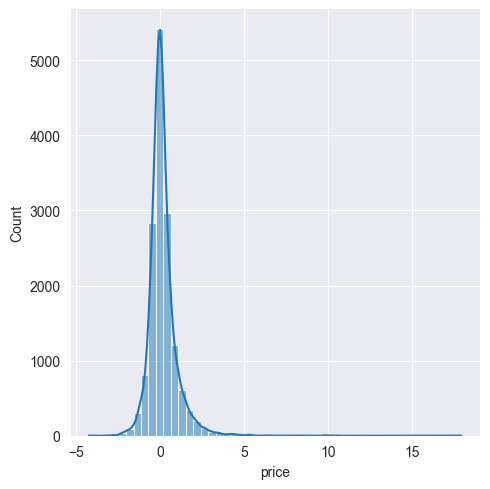

In [51]:
sns.displot(y_test-linear_test_preds, bins=50, kde=True);

In [52]:
linear_coefs = linear_pipe['target_regressor'].regressor_.coef_
linear_coefs

array([ 0.14034017, -0.2082576 , -0.00368753, -0.13736327,  0.06651777,
       -0.01119964, -0.07855848, -0.0348379 ,  0.02536151,  0.04852315,
       -0.04118911,  0.00893078, -0.0075834 ,  0.00511104,  0.04639531,
        0.04967428,  0.03388656, -0.00340216, -0.00849814,  0.02241257])

In [53]:
X_train.iloc[:,linear_coefs!=0].columns

Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19], dtype='int64')

In [54]:
linear_PCA_coef = pd.DataFrame(linear_coefs[linear_coefs != 0], columns=['coef_best_model'], index=X_train.iloc[:,linear_coefs!=0].columns)

In [55]:
# Extract the column names from top_features excluding the index
feature_columns = top_component_features_df.columns

# Create a new DataFrame that includes the top 5 features for each principal component
linear_PCA_feature_association = pd.DataFrame({
    'PCA Coefficient': linear_PCA_coef['coef_best_model'].values,
    'Top Features': [', '.join(top_component_features_df[col].values) for col in feature_columns]
}, index=feature_columns).sort_values(by='PCA Coefficient', ascending=False)

# Set the display options to show all columns
pd.set_option('max_colwidth', 50)

# Display the DataFrame
print(linear_PCA_feature_association)

# write to csv
linear_PCA_feature_association.to_csv('linear_PCA_feature_association.csv')

      PCA Coefficient                                       Top Features
PC1          0.140340                         cylinders, size, drive_fwd
PC5          0.066518           type_sedan, drive_fwd, paint_color_white
PC16         0.049674         manufacturer_toyota, type_pickup, fuel_gas
PC10         0.048523                type_truck, type_pickup, type_sedan
PC15         0.046395                   state_ca, type_pickup, drive_fwd
PC17         0.033887  manufacturer_toyota, fuel_gas, manufacturer_honda
PC9          0.025362  paint_color_silver, paint_color_grey, paint_co...
PC20         0.022413  manufacturer_honda, manufacturer_nissan, state_ny
PC12         0.008931  paint_color_blue, paint_color_grey, manufactur...
PC14         0.005111  paint_color_red, manufacturer_chevrolet, paint...
PC18        -0.003402            transmission_manual, state_fl, state_ny
PC3         -0.003688                          size, cylinders, odometer
PC13        -0.007583                    state_ca, 

##### Ridge Regression

In [56]:
ridge_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('target_regressor', TransformedTargetRegressor(regressor=Ridge(), func=np.log1p, inverse_func=np.expm1))
])
ridge_pipe

Pipeline(steps=[('scaler', StandardScaler()),
                ('target_regressor',
                 TransformedTargetRegressor(func=<ufunc 'log1p'>,
                                            inverse_func=<ufunc 'expm1'>,
                                            regressor=Ridge()))])

In [57]:
# Define the parameter grid for Ridge
ridge_param_grid = {'target_regressor__regressor__alpha': [0.1, 1, 10, 100, 1000]}

# Set up the grid search for Ridge
grid_search_ridge = GridSearchCV(ridge_pipe, ridge_param_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True)
#grid_search_ridge.fit(X_train, y_train.values.ravel())
grid_search_ridge.fit(X_final, y.values.ravel())

# Perform K-Fold cross-validation and calculate negative mean squared error for ridge regression model
ridge_nmse_scores = cross_val_score(ridge_pipe, X_train, y_train.values.ravel(), cv=5, scoring='neg_mean_squared_error')

# Print the cross-validation results
print('Ridge Regression Cross Validation Negative Mean Squared Error Scores: %s' % ridge_nmse_scores)
print('Ridge Regression Cross Validation Negative Mean Squared Error: %.3f +/- %.3f' % (np.mean(ridge_nmse_scores), np.std(ridge_nmse_scores)))

Ridge Regression Cross Validation Negative Mean Squared Error Scores: [-0.76055127 -0.7142989  -0.70042113 -0.70657482 -0.75486025]
Ridge Regression Cross Validation Negative Mean Squared Error: -0.727 +/- 0.025


In [58]:
# Perform cross-validation and calculate R^2 scores
# ridge_R2_scores = cross_val_score(ridge_pipe, X_train, y_train.values.ravel(), cv=5, scoring='r2')
ridge_R2_scores = cross_val_score(ridge_pipe, X_final, y.values.ravel(), cv=5, scoring='r2')

# Print the cross-validation results
print('Ridge Regression Cross Validation R^2 Scores: %s' % ridge_R2_scores)
print('Ridge Regression Cross Validation R^2: %.3f +/- %.3f' % (np.mean(ridge_R2_scores), np.std(ridge_R2_scores)))

Ridge Regression Cross Validation R^2 Scores: [0.30798309 0.53910855 0.53070784 0.53844936 0.54267422]
Ridge Regression Cross Validation R^2: 0.492 +/- 0.092


In [59]:
# Fit the pipeline to the training data
ridge_pipe.fit(X_train, y_train)

# Make predictions on the test data
ridge_train_preds = ridge_pipe.predict(X_train)
ridge_test_preds = ridge_pipe.predict(X_test)

# Calculate mean squared error
ridge_train_mse = mean_squared_error(y_train,ridge_train_preds)
ridge_test_mse = mean_squared_error(y_test, ridge_test_preds)

# Print the results
print(f'Ridge Regression Train MSE: {ridge_train_mse}')
print(f'Ridge Regression Test MSE: {ridge_test_mse}')
print(f'Ridge Regression Score::{r2_score(y_true=y_test, y_pred=ridge_test_preds)}')

Ridge Regression Train MSE: 0.7266069993504187
Ridge Regression Test MSE: 0.7431375615103181
Ridge Regression Score::0.5313587791790986


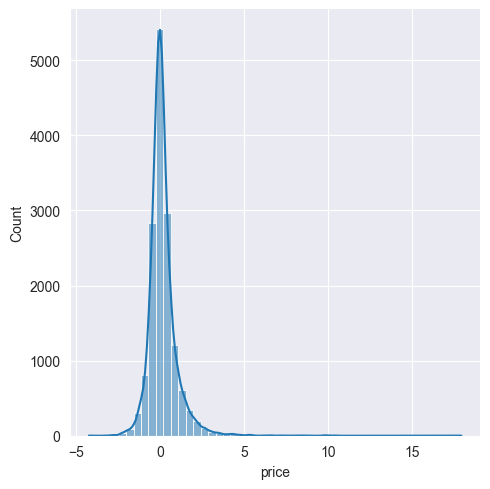

In [60]:
sns.displot(y_test-ridge_test_preds, bins=50, kde=True);

In [61]:
best_ridge_estimator = grid_search_ridge.best_estimator_

In [62]:
best_ridge_coefs = best_ridge_estimator['target_regressor'].regressor_.coef_
best_ridge_coefs

array([ 0.13862902, -0.20600127, -0.00409731, -0.13608271,  0.06535281,
       -0.01164434, -0.07695116, -0.0339833 ,  0.02433504,  0.0486497 ,
       -0.04028465,  0.00871735, -0.00747163,  0.00545864,  0.04515668,
        0.04944546,  0.03333023, -0.00332735, -0.00842346,  0.02233313])

In [63]:
X_train.iloc[:,best_ridge_estimator['target_regressor'].regressor_.coef_!=0].columns

Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19], dtype='int64')

In [64]:
ridge_PCA_coef = pd.DataFrame(best_ridge_coefs, columns=['coef_best_model'], index=X_train.iloc[:,best_ridge_coefs!=0].columns)
ridge_PCA_coef

,coef_best_model
0,0.138629
1,-0.206001
2,-0.004097
3,-0.136083
4,0.065353
5,-0.011644
6,-0.076951
7,-0.033983
8,0.024335
9,0.048650


In [65]:
ridge_PCA_coef_sorted = ridge_PCA_coef.sort_values(by='coef_best_model', ascending=False)
print(ridge_PCA_coef_sorted)

    coef_best_model
0          0.138629
4          0.065353
15         0.049445
9          0.048650
14         0.045157
16         0.033330
8          0.024335
19         0.022333
11         0.008717
13         0.005459
17        -0.003327
2         -0.004097
12        -0.007472
18        -0.008423
5         -0.011644
7         -0.033983
10        -0.040285
6         -0.076951
3         -0.136083
1         -0.206001


In [66]:
# Extract the column names from top_features excluding the index
feature_columns = top_component_features_df.columns

# Create a new DataFrame that includes the top 5 features for each principal component
ridge_PCA_feature_association = pd.DataFrame({
    'PCA Coefficient': ridge_PCA_coef['coef_best_model'].values,
    'Top Features': [', '.join(top_component_features_df[col].values) for col in feature_columns]
}, index=feature_columns).sort_values(by='PCA Coefficient', ascending=False)

# Set the maximum column width
pd.set_option('max_colwidth', 50)

# Display the DataFrame
print(ridge_PCA_feature_association)

# write to csv
ridge_PCA_feature_association.to_csv('Ridge_PCA_feature_association.csv', index=False)

      PCA Coefficient                                       Top Features
PC1          0.138629                         cylinders, size, drive_fwd
PC5          0.065353           type_sedan, drive_fwd, paint_color_white
PC16         0.049445         manufacturer_toyota, type_pickup, fuel_gas
PC10         0.048650                type_truck, type_pickup, type_sedan
PC15         0.045157                   state_ca, type_pickup, drive_fwd
PC17         0.033330  manufacturer_toyota, fuel_gas, manufacturer_honda
PC9          0.024335  paint_color_silver, paint_color_grey, paint_co...
PC20         0.022333  manufacturer_honda, manufacturer_nissan, state_ny
PC12         0.008717  paint_color_blue, paint_color_grey, manufactur...
PC14         0.005459  paint_color_red, manufacturer_chevrolet, paint...
PC18        -0.003327            transmission_manual, state_fl, state_ny
PC3         -0.004097                          size, cylinders, odometer
PC13        -0.007472                    state_ca, 

In [67]:
grid_search_ridge.cv_results_

{'mean_fit_time': array([0.04782977, 0.0363884 , 0.01550412, 0.01477637, 0.0170846 ]),
 'std_fit_time': array([0.0471662 , 0.04041771, 0.0041788 , 0.00101634, 0.00362761]),
 'mean_score_time': array([0.03069043, 0.00939207, 0.00284038, 0.00351896, 0.00262966]),
 'std_score_time': array([0.05120053, 0.00579425, 0.00263505, 0.00246657, 0.00144192]),
 'param_target_regressor__regressor__alpha': masked_array(data=[0.1, 1, 10, 100, 1000],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'target_regressor__regressor__alpha': 0.1},
  {'target_regressor__regressor__alpha': 1},
  {'target_regressor__regressor__alpha': 10},
  {'target_regressor__regressor__alpha': 100},
  {'target_regressor__regressor__alpha': 1000}],
 'split0_test_score': array([-1.16920613, -1.16848093, -1.16135446, -1.10095012, -0.90556397]),
 'split1_test_score': array([-0.71077098, -0.71077298, -0.71079338, -0.71103689, -0.71603231]),
 'split2_test_scor

##### Lasso Regression

In [68]:
lasso_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('target_regressor', TransformedTargetRegressor(regressor=Lasso(), func=np.log1p, inverse_func=np.expm1))
])
lasso_pipe

Pipeline(steps=[('scaler', StandardScaler()),
                ('target_regressor',
                 TransformedTargetRegressor(func=<ufunc 'log1p'>,
                                            inverse_func=<ufunc 'expm1'>,
                                            regressor=Lasso()))])

In [69]:
# Define the parameter grid for Lasso
lasso_param_grid = {'target_regressor__regressor__alpha': [0.001, 0.01, 0.1, 1, 10]}

# Set up the grid search for Lasso
grid_search_lasso = GridSearchCV(lasso_pipe, lasso_param_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True)
#grid_search_lasso.fit(X_train, y_train.values.ravel())
grid_search_lasso.fit(X_final, y.values.ravel())

# Perform cross-validation and calculate negative mean squared error for lasso regression model
# lasso_nmse_scores = cross_val_score(lasso_pipe, X_train, y_train.values.ravel(), cv=5, scoring='neg_mean_squared_error')
lasso_nmse_scores = cross_val_score(lasso_pipe, X_final, y.values.ravel(), cv=5, scoring='neg_mean_squared_error')

# Print the cross-validation results
print('Lasso Regression Cross Validation Negative Mean Squared Error Scores: %s' % lasso_nmse_scores)
print('Lasso Regression Cross Validation Negative Mean Squared Error: %.3f +/- %.3f' % (np.mean(lasso_nmse_scores), np.std(lasso_nmse_scores)))

Lasso Regression Cross Validation Negative Mean Squared Error Scores: [-1.75581293 -1.60795053 -1.68992628 -1.34886626 -1.66596082]
Lasso Regression Cross Validation Negative Mean Squared Error: -1.614 +/- 0.141


In [70]:
# Perform cross-validation and calculate R^2 scores
#lasso_R2_scores = cross_val_score(lasso_pipe, X_train, y_train.values.ravel(), cv=5, scoring='r2')
lasso_R2_scores = cross_val_score(lasso_pipe, X_final, y.values.ravel(), cv=5, scoring='r2')

# Print the cross-validation results
print('Lasso Regression Cross Validation R^2 Scores: %s' % lasso_R2_scores)
print('Lasso Regression Cross Validation R^2: %.3f +/- %.3f' % (np.mean(lasso_R2_scores), np.std(lasso_R2_scores)))

Lasso Regression Cross Validation R^2 Scores: [-0.03985629 -0.04265451 -0.04926865 -0.00166796 -0.06479544]
Lasso Regression Cross Validation R^2: -0.040 +/- 0.021


In [71]:
# Fit the pipeline to the training data
lasso_pipe.fit(X_train, y_train)
    
# Make predictions on the test data
lasso_train_preds = lasso_pipe.predict(X_train)
lasso_test_preds = lasso_pipe.predict(X_test)

# Calculate mean squared error
lasso_train_mse = mean_squared_error(y_train, lasso_train_preds)
lasso_test_mse = mean_squared_error(y_test, lasso_test_preds)

# Print the results
print(f'Lasso Regression Train MSE: {lasso_train_mse}')
print(f'Lasso Regression Test MSE: {lasso_test_mse}')
print(f'Lasso Regression Score::{r2_score(y_true=y_test, y_pred=lasso_test_preds)}')

Lasso Regression Train MSE: 1.6032631810810012
Lasso Regression Test MSE: 1.644531122166287
Lasso Regression Score::-0.037082651566758384


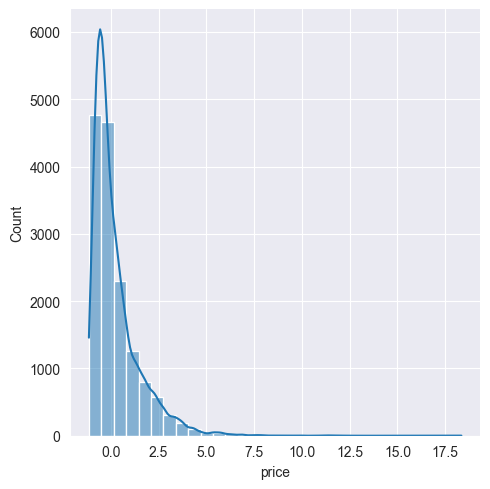

In [72]:
sns.displot(y_test-lasso_test_preds, bins=30, kde=True);

In [73]:
best_lasso_estimator = grid_search_lasso.best_estimator_
best_lasso_coefs = best_lasso_estimator['target_regressor'].regressor_.coef_
best_lasso_coefs

array([ 0.13946562, -0.20773045, -0.00315159, -0.13688558,  0.06521863,
       -0.01079861, -0.07697064, -0.03343353,  0.02365743,  0.04829423,
       -0.03981836,  0.00783284, -0.00657062,  0.00453096,  0.04475493,
        0.04910053,  0.0327718 , -0.00237143, -0.00753506,  0.02162901])

In [74]:
X_train.iloc[:,best_lasso_coefs!=0].columns

Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19], dtype='int64')

In [75]:
lasso_PCA_coef = pd.DataFrame(best_lasso_coefs, columns=['coef_best_model'], index = X_train.iloc[:,best_lasso_coefs!=0].columns)
print(lasso_PCA_coef)

    coef_best_model
0          0.139466
1         -0.207730
2         -0.003152
3         -0.136886
4          0.065219
5         -0.010799
6         -0.076971
7         -0.033434
8          0.023657
9          0.048294
10        -0.039818
11         0.007833
12        -0.006571
13         0.004531
14         0.044755
15         0.049101
16         0.032772
17        -0.002371
18        -0.007535
19         0.021629


In [76]:
lasso_PCA_coef_sorted = lasso_PCA_coef.sort_values(by='coef_best_model', ascending=False)
print(lasso_PCA_coef_sorted)

    coef_best_model
0          0.139466
4          0.065219
15         0.049101
9          0.048294
14         0.044755
16         0.032772
8          0.023657
19         0.021629
11         0.007833
13         0.004531
17        -0.002371
2         -0.003152
12        -0.006571
18        -0.007535
5         -0.010799
7         -0.033434
10        -0.039818
6         -0.076971
3         -0.136886
1         -0.207730


In [77]:
# Extract the column names from top_features excluding the index
feature_columns = top_component_features_df.columns

# Create a new DataFrame that includes the top 5 features for each principal component
lasso_PCA_feature_association = pd.DataFrame({
    'PCA Coefficient': lasso_PCA_coef['coef_best_model'].values,
    'Top Features': [', '.join(top_component_features_df[col].values) for col in feature_columns]
}, index=feature_columns).sort_values(by='PCA Coefficient', ascending=False)

# Set the maximum column width
pd.set_option('max_colwidth', 50)

# Display the DataFrame
print(lasso_PCA_feature_association)

# write to csv
lasso_PCA_feature_association.to_csv('lasso_PCA_feature_association.csv', index=False)

      PCA Coefficient                                       Top Features
PC1          0.139466                         cylinders, size, drive_fwd
PC5          0.065219           type_sedan, drive_fwd, paint_color_white
PC16         0.049101         manufacturer_toyota, type_pickup, fuel_gas
PC10         0.048294                type_truck, type_pickup, type_sedan
PC15         0.044755                   state_ca, type_pickup, drive_fwd
PC17         0.032772  manufacturer_toyota, fuel_gas, manufacturer_honda
PC9          0.023657  paint_color_silver, paint_color_grey, paint_co...
PC20         0.021629  manufacturer_honda, manufacturer_nissan, state_ny
PC12         0.007833  paint_color_blue, paint_color_grey, manufactur...
PC14         0.004531  paint_color_red, manufacturer_chevrolet, paint...
PC18        -0.002371            transmission_manual, state_fl, state_ny
PC3         -0.003152                          size, cylinders, odometer
PC13        -0.006571                    state_ca, 

In [78]:
grid_search_lasso.cv_results_

{'mean_fit_time': array([0.93772464, 0.31263108, 0.25344181, 0.08197227, 0.05647159]),
 'std_fit_time': array([1.26513144, 0.03554893, 0.0075253 , 0.04584936, 0.02625356]),
 'mean_score_time': array([0.03799191, 0.09835672, 0.05609684, 0.04567113, 0.04754744]),
 'std_score_time': array([0.02390418, 0.03056189, 0.02245439, 0.0291881 , 0.01813296]),
 'param_target_regressor__regressor__alpha': masked_array(data=[0.001, 0.01, 0.1, 1, 10],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'target_regressor__regressor__alpha': 0.001},
  {'target_regressor__regressor__alpha': 0.01},
  {'target_regressor__regressor__alpha': 0.1},
  {'target_regressor__regressor__alpha': 1},
  {'target_regressor__regressor__alpha': 10}],
 'split0_test_score': array([-0.8529531 , -0.89288108, -1.39992463, -1.75581293, -1.75581293]),
 'split1_test_score': array([-0.71365443, -0.75843645, -1.25983746, -1.60795053, -1.60795053]),
 'split2_test_

### Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight on drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

#### Metrics Summary

Linear Regression:
- Cross Validation Negative Mean Squared Error (MSE): -0.886 ± 0.101
- Cross Validation R²: 0.492 ± 0.092
- Train MSE: 0.727
- Test MSE: 0.743
- Score: 0.531

Ridge Regression:
- Cross Validation Negative MSE: -0.727 ± 0.025
- Cross Validation R²: 0.492 ± 0.092
- Train MSE: 0.727
- Test MSE: 0.743
- Score: 0.531

Lasso Regression:
- Cross Validation Negative MSE: -1.614 ± 0.141
- Cross Validation R²: -0.040 ± 0.021
- Train MSE: 1.603
- Test MSE: 1.645
- Score: -0.037

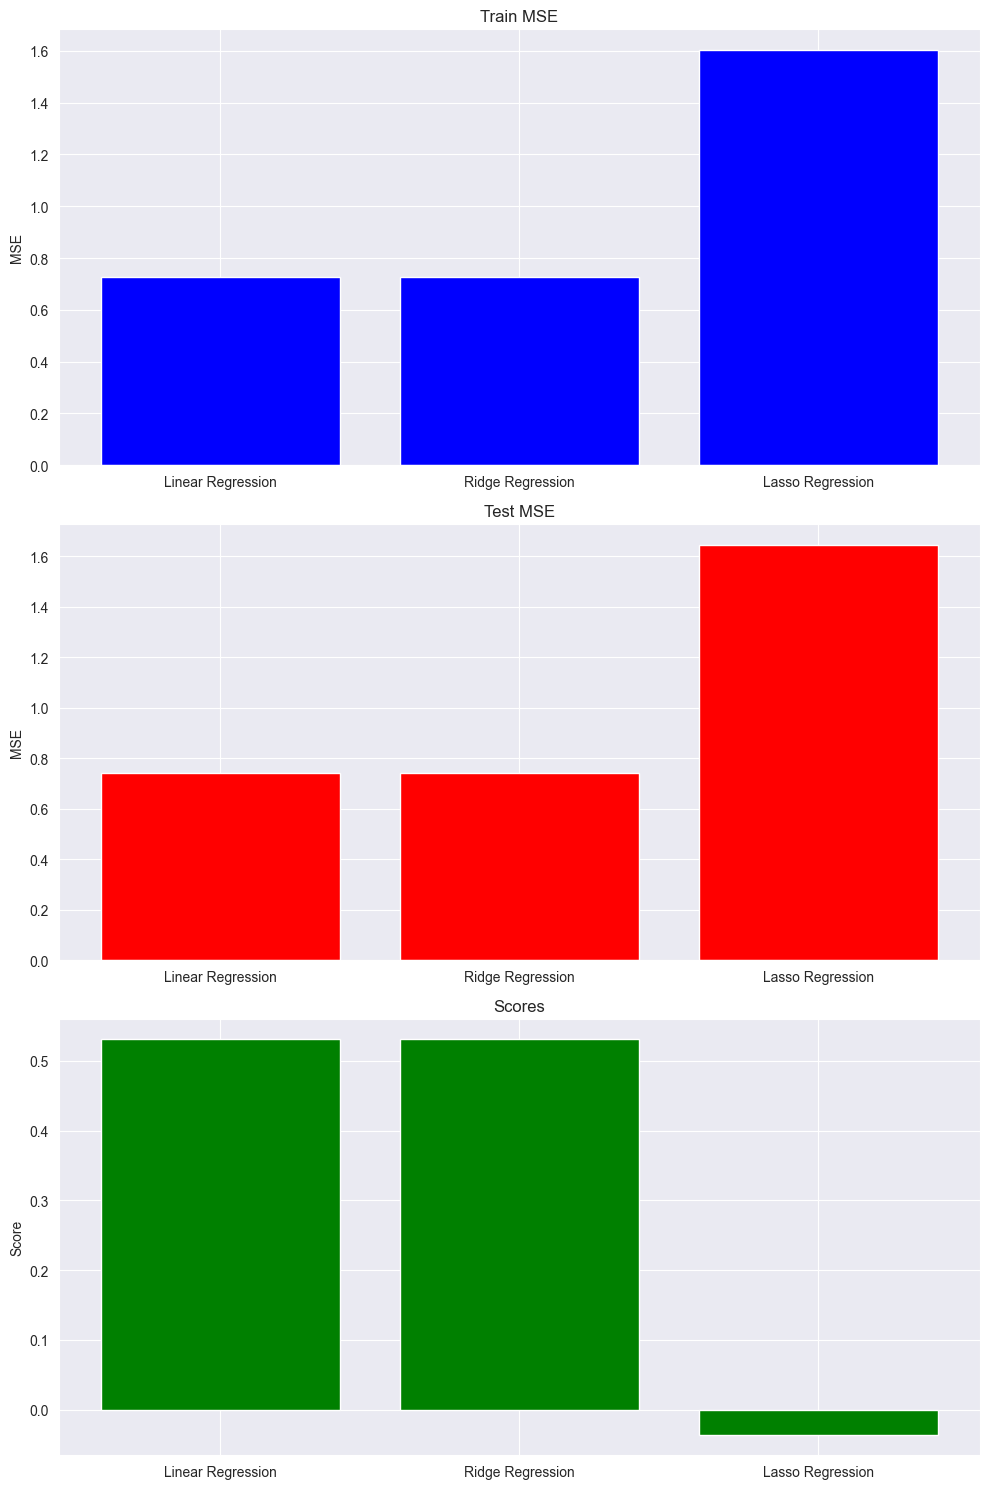

In [79]:
# Data for plotting
models = ['Linear Regression', 'Ridge Regression', 'Lasso Regression']
train_mse = [0.727, 0.727, 1.603]
test_mse = [0.743, 0.743, 1.645]
scores = [0.531, 0.531, -0.037]

# Sorting based on test MSE for visualization
sorted_indices = np.argsort(test_mse)
models_sorted = [models[i] for i in sorted_indices]
train_mse_sorted = [train_mse[i] for i in sorted_indices]
test_mse_sorted = [test_mse[i] for i in sorted_indices]
scores_sorted = [scores[i] for i in sorted_indices]

# Plotting
fig, ax = plt.subplots(3, 1, figsize=(10, 15), facecolor='white')

ax[0].bar(models_sorted, train_mse_sorted, color='blue')
ax[0].set_title('Train MSE')
ax[0].set_ylabel('MSE')

ax[1].bar(models_sorted, test_mse_sorted, color='red')
ax[1].set_title('Test MSE')
ax[1].set_ylabel('MSE')

ax[2].bar(models_sorted, scores_sorted, color='green')
ax[2].set_title('Scores')
ax[2].set_ylabel('Score')

plt.tight_layout()
plt.show()

#### Metrics Analysis:

Train and Test MSE: Ridge Regression has the lowest Mean Squared Error (MSE) for both training and testing, indicating it might be handling overfitting slightly better than Linear Regression, which has similar values. Lasso Regression, however, shows significantly higher MSE values, suggesting it might not be fitting the data well.
<br /><br />
Scores: Ridge and Linear Regression have similar scores, which are substantially higher than the negative score of Lasso Regression. This further supports that Lasso Regression is underperforming compared to the other two models in this dataset.
<br /><br />
These visualizations clearly show that Ridge Regression, while having similar performance metrics to Linear Regression, might be slightly more robust given its lower MSE values. Lasso Regression, on the other hand, appears to be the least effective model for this particular dataset.

### Conclusions and Next Steps:

Permutation Importance Findings:
The odometer feature has the highest importance, suggesting mileage is a crucial factor in predicting vehicle price.
Fuel-related features, year, and condition of the vehicle also show notable importance.
Geographic location, manufacturer, and vehicle type also influence vehicle prices.
<br /><br />
Regression Model Findings:
Ridge, Linear, and Lasso regression models all show a positive influence of features like 'cylinders', 'size', 'drive_fwd', and 'type_sedan' on vehicle price.
The Ridge model appears to perform better than the other models based on the reported performance metrics.
The Linear Regression model faced issues with the original dataset, requiring the use of Principal Component Analysis (PCA) to reduce dimensionality.
<br /><br />
Potential Next Steps:<br />
- Feature Engineering - Explore additional features that could further improve the predictive power of the models, such as detailed vehicle specifications, market trends, or economic factors.
<br /><br />
- Model Comparison and Tuning - Conduct a more comprehensive comparison of these and other regression models, including hyperparameter tuning and cross-validation to ensure robust performance.
<br /><br />
- Handling Dimensionality - Investigate alternative approaches to address the dimensionality issues encountered with the Linear Regression model, such as feature selection or other dimensionality reduction techniques.
<br /><br />
- Interpretability - Provide more detailed explanations of the feature importance and the relationships between the predictors and the target variable (vehicle price) to enhance the interpretability of the models.
<br /><br />
- Real-world Deployment - Consider deploying the best-performing model in a real-world application, such as a vehicle pricing tool or a decision support system for buyers and sellers.

### Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine tuning their inventory.